In [1]:
import sys
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

import importlib
if '/opt/notebooks/' not in sys.path:
    sys.path.append('/opt/notebooks/')

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
DIRS = sl.get_dirs()
M_PARAMS = sl.get_model_params()

# Get data for testing

# A very basic network

## Set model

https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767

In [3]:
num_epochs = 20
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

## Building the computational graph
https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767

### Variables and placeholders

In [5]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [6]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

### Unpacking (or unstacking)

In [7]:
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [8]:
inputs_series

[<tf.Tensor 'unstack:0' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:1' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:2' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:3' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:4' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:5' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:6' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:7' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:8' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:9' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:10' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:11' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:12' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:13' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:14' shape=(5,) dtype=float32>]

### Forward pass

In [9]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

### Calculating loss

In [10]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

### Visualizing the training

In [4]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

### Running a training session

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.8556402


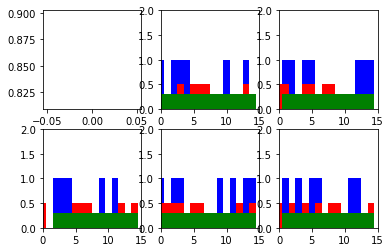

Step 100 Loss 0.6905209


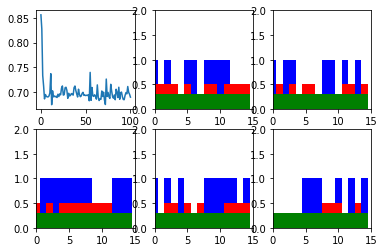

Step 200 Loss 0.6992068


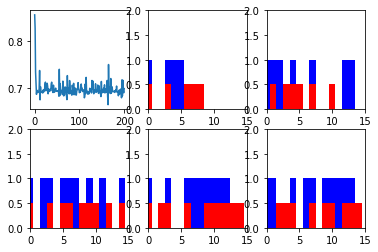

Step 300 Loss 0.70954394


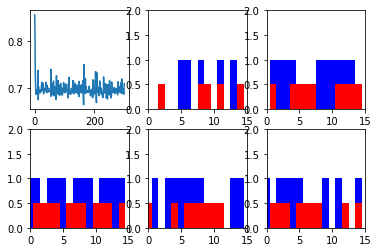

Step 400 Loss 0.6922239


KeyboardInterrupt: 

In [12]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

## A bit more clever model
https://medium.com/@erikhallstrm/tensorflow-rnn-api-2bb31821b185

In [13]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [15]:
# Unpack columns
inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
states_series, current_state = tf.nn.static_rnn(cell, inputs_series, init_state)

In [16]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.6982855


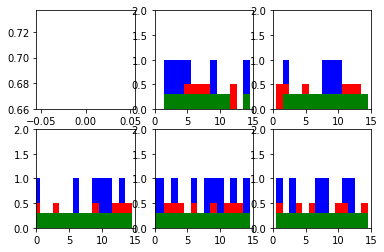

Step 100 Loss 0.013246939


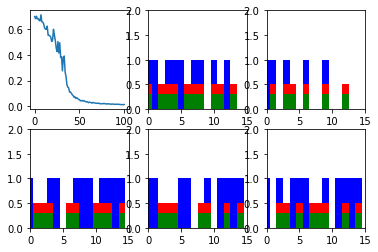

Step 200 Loss 0.008279111


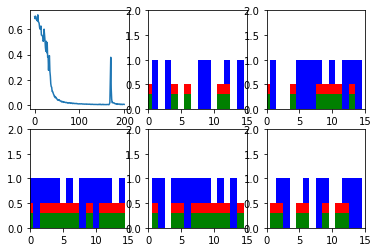

Step 300 Loss 0.0034963607


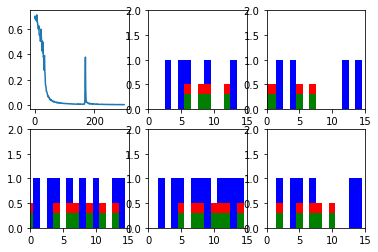

Step 400 Loss 0.00208223


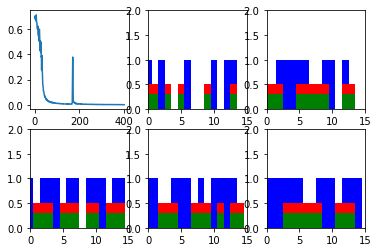

Step 500 Loss 0.0017952062


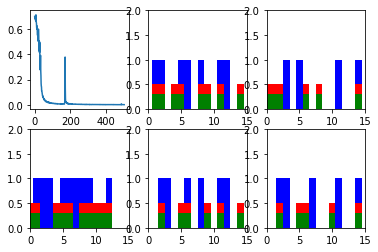

Step 600 Loss 0.001557593


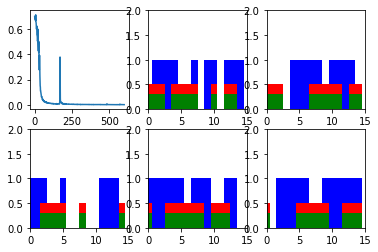

New data, epoch 1
Step 0 Loss 0.15199867


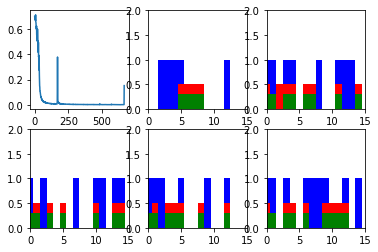

Step 100 Loss 0.0011497578


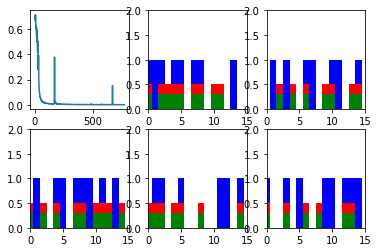

Step 200 Loss 0.0012072121


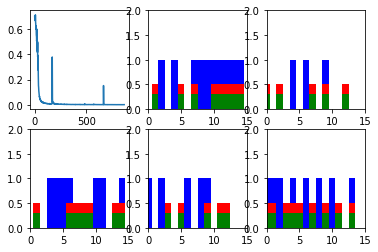

Step 300 Loss 0.0007493489


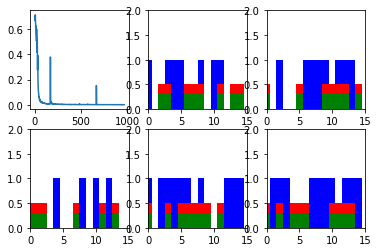

Step 400 Loss 0.000710824


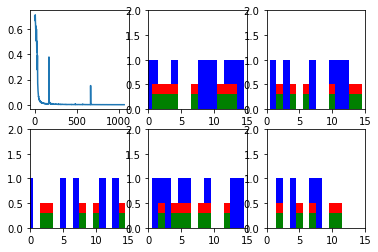

Step 500 Loss 0.0007313626


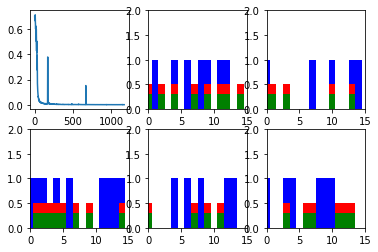

Step 600 Loss 0.0006299488


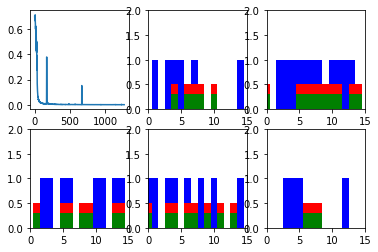

New data, epoch 2
Step 0 Loss 0.26751977


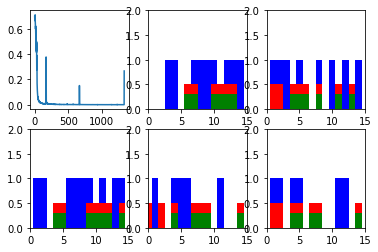

Step 100 Loss 0.00074356975


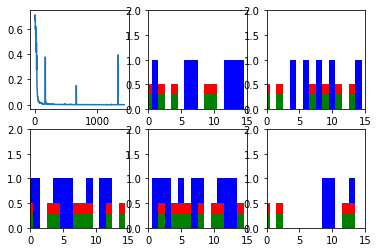

Step 200 Loss 0.00065260654


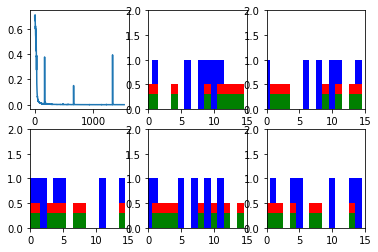

Step 300 Loss 0.0006024815


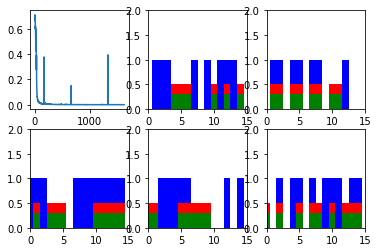

Step 400 Loss 0.0005332958


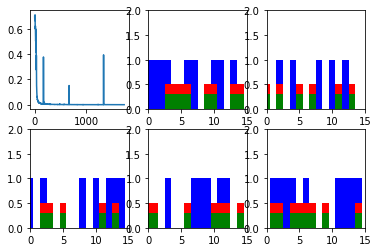

Step 500 Loss 0.0005430037


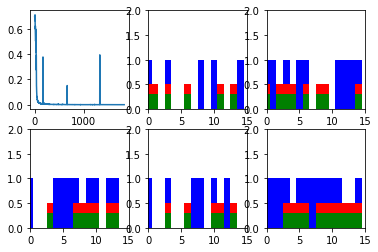

Step 600 Loss 0.0005264984


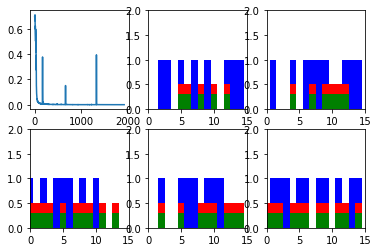

New data, epoch 3
Step 0 Loss 0.116931506


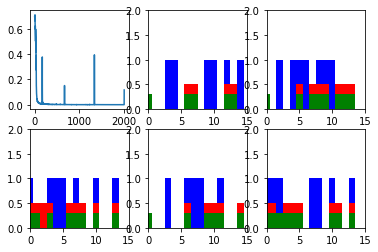

Step 100 Loss 0.00038719067


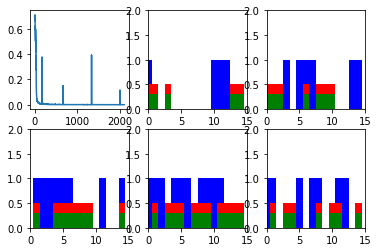

Step 200 Loss 0.00039393836


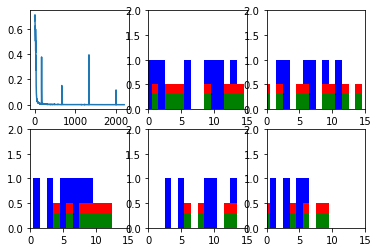

Step 300 Loss 0.00032965202


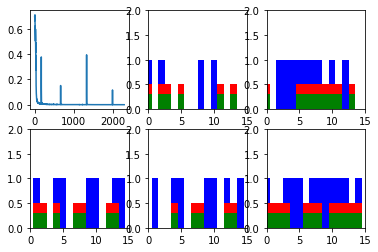

Step 400 Loss 0.0003003399


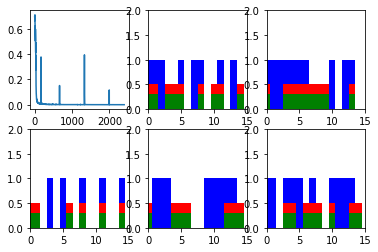

Step 500 Loss 0.00034821747


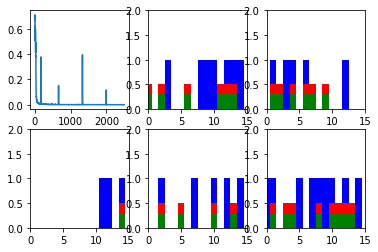

Step 600 Loss 0.0003380571


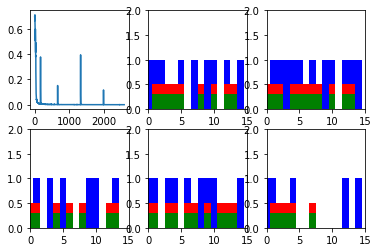

New data, epoch 4
Step 0 Loss 0.21497773


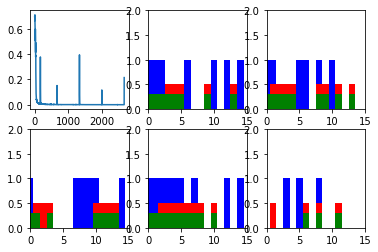

Step 100 Loss 0.00032263552


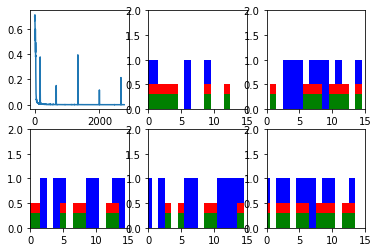

Step 200 Loss 0.00029311565


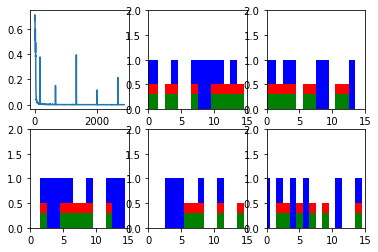

Step 300 Loss 0.00031140816


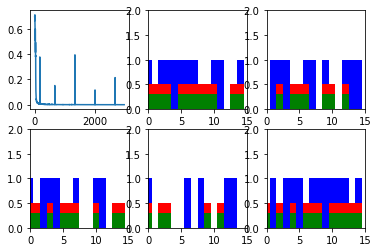

Step 400 Loss 0.00057091325


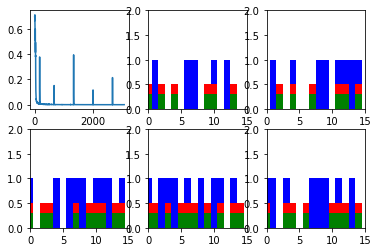

Step 500 Loss 0.0002645592


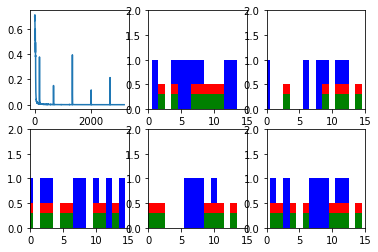

Step 600 Loss 0.00026720585


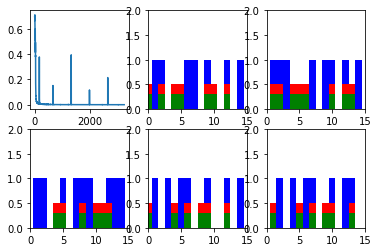

New data, epoch 5
Step 0 Loss 0.15341614


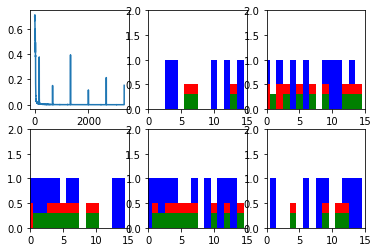

Step 100 Loss 0.00039618427


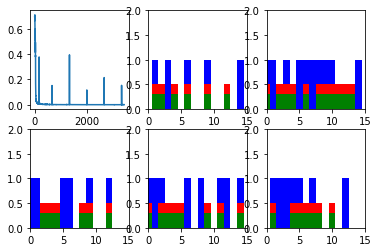

Step 200 Loss 0.00029840012


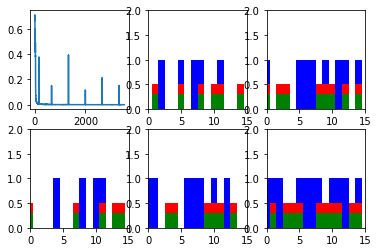

Step 300 Loss 0.0002890405


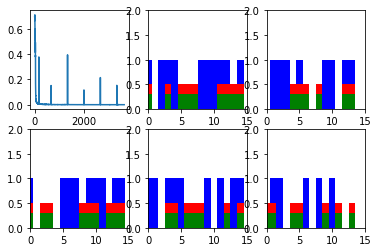

Step 400 Loss 0.000247505


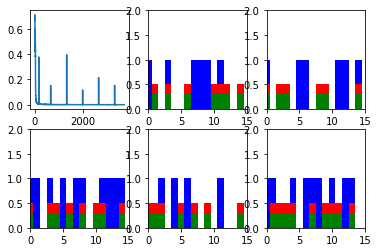

Step 500 Loss 0.00020743022


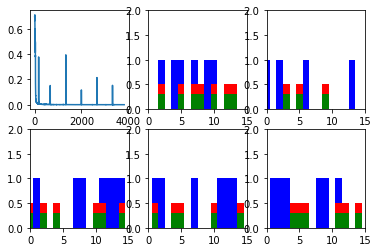

Step 600 Loss 0.0002527078


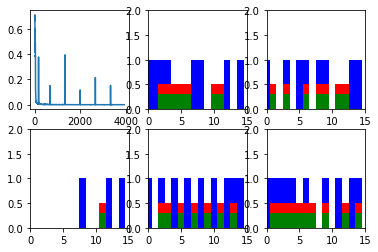

New data, epoch 6
Step 0 Loss 0.25680906


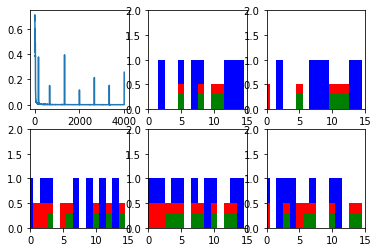

Step 100 Loss 0.00031917397


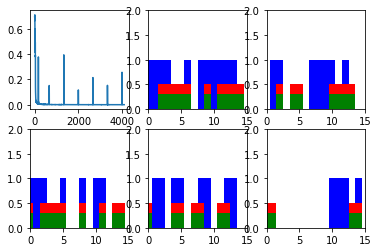

Step 200 Loss 0.0003200168


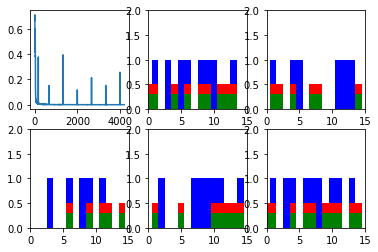

Step 300 Loss 0.0002946855


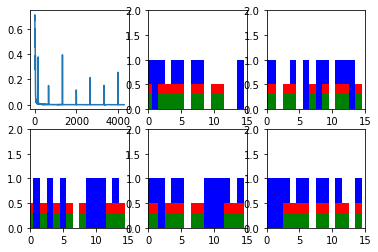

Step 400 Loss 0.0002510799


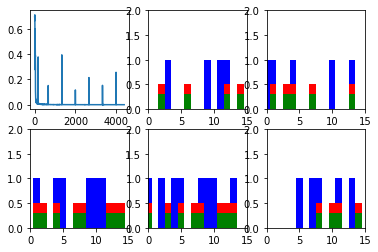

Step 500 Loss 0.00024263379


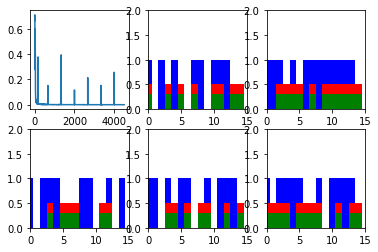

Step 600 Loss 0.00025719928


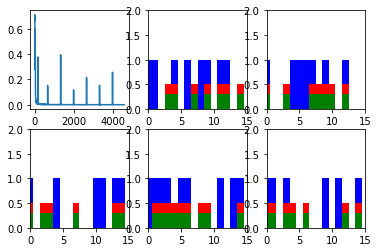

New data, epoch 7
Step 0 Loss 0.4298251


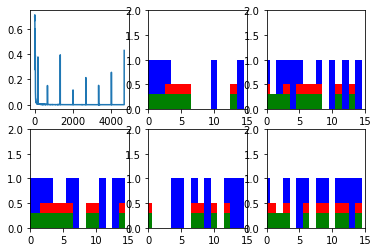

Step 100 Loss 0.00027233074


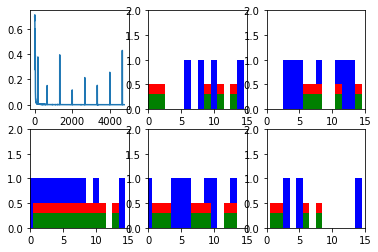

Step 200 Loss 0.00024521316


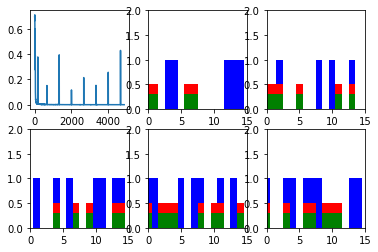

Step 300 Loss 0.00024086528


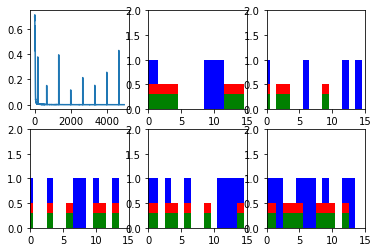

Step 400 Loss 0.00023651737


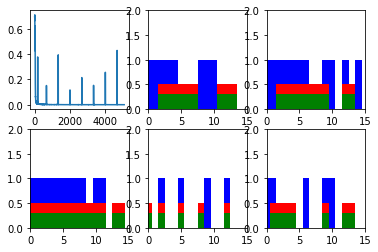

Step 500 Loss 0.00027099554


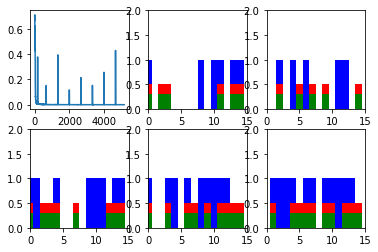

Step 600 Loss 0.00018952061


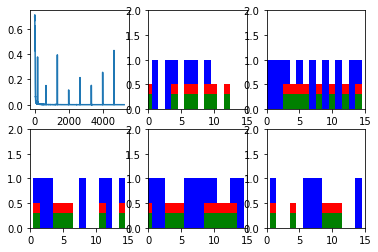

New data, epoch 8
Step 0 Loss 0.24153669


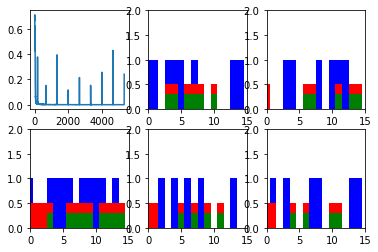

Step 100 Loss 0.00018646351


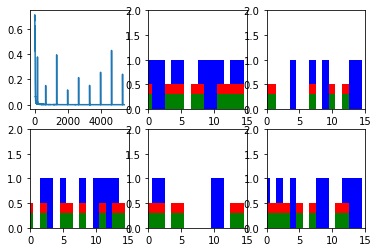

Step 200 Loss 0.00014600725


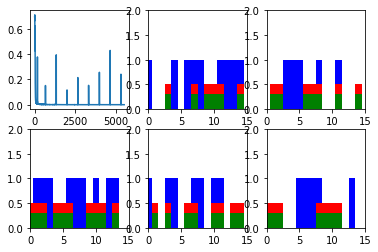

Step 300 Loss 0.00017605706


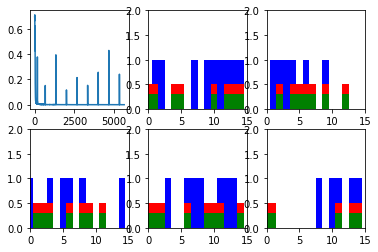

Step 400 Loss 0.00017437991


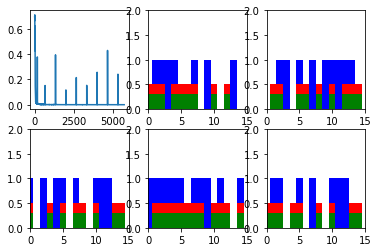

Step 500 Loss 0.00012851991


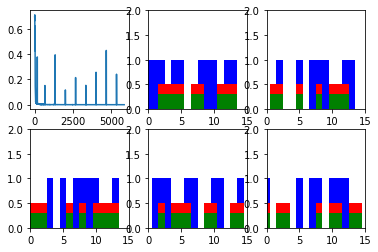

Step 600 Loss 0.00015479886


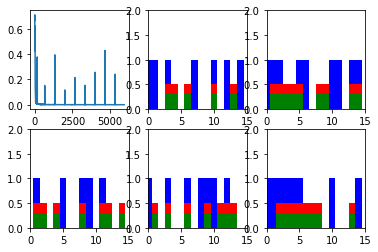

New data, epoch 9
Step 0 Loss 0.15876548


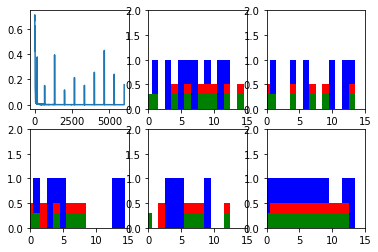

Step 100 Loss 0.00015596561


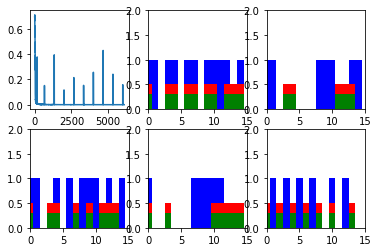

Step 200 Loss 0.00013483621


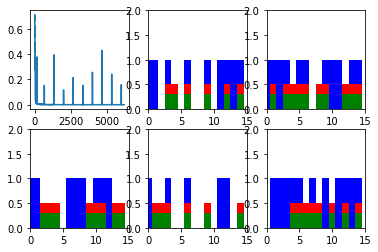

Step 300 Loss 0.00014950764


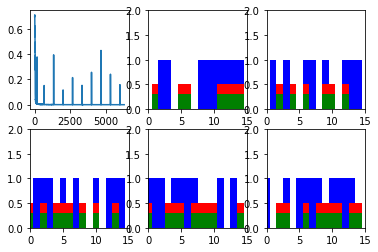

Step 400 Loss 0.0001469723


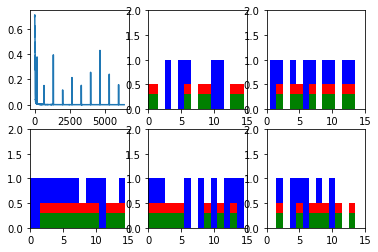

Step 500 Loss 0.00013401255


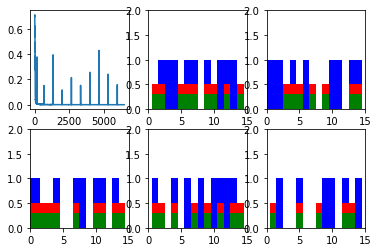

Step 600 Loss 0.00013240283


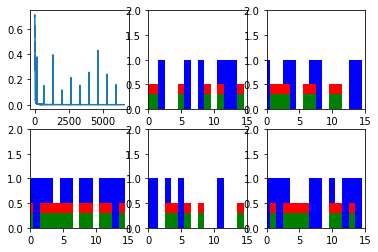

New data, epoch 10
Step 0 Loss 0.23534058


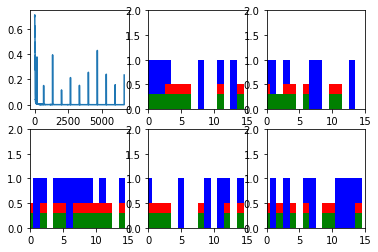

Step 100 Loss 0.00011632482


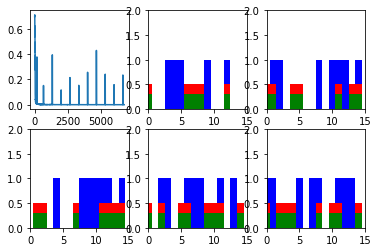

Step 200 Loss 0.00013350137


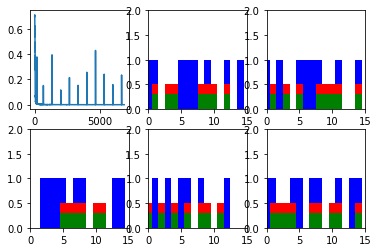

Step 300 Loss 0.00013189923


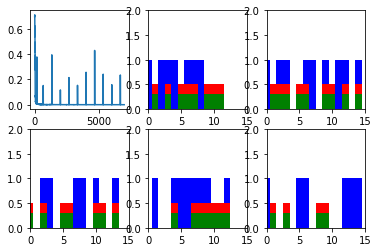

Step 400 Loss 0.0001457403


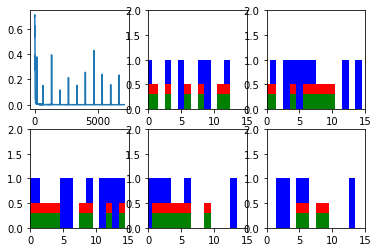

Step 500 Loss 0.00010924783


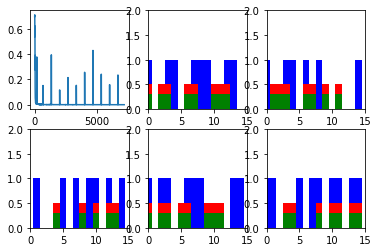

Step 600 Loss 0.00012994547


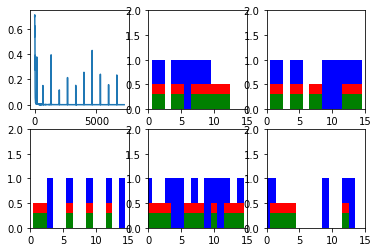

New data, epoch 11
Step 0 Loss 0.32693768


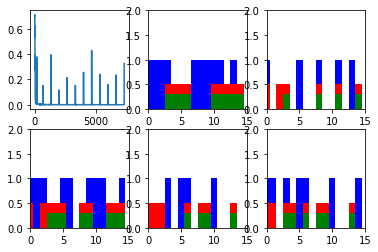

Step 100 Loss 0.00013656495


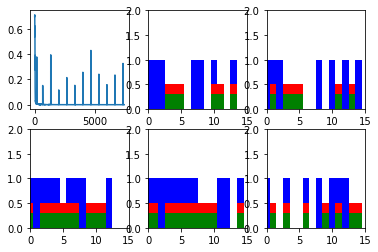

Step 200 Loss 0.00013764921


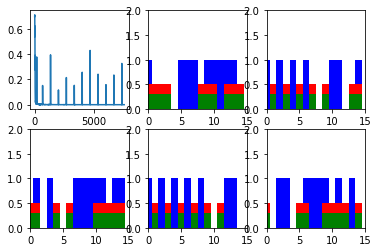

Step 300 Loss 0.00015430438


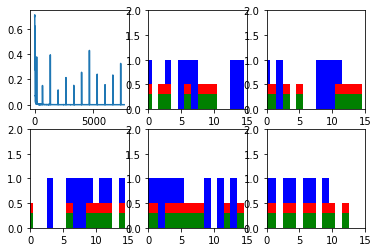

Step 400 Loss 0.00013483367


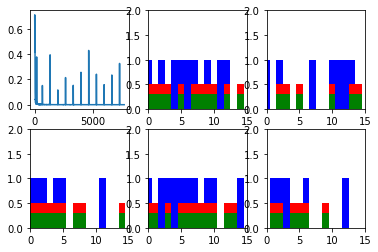

Step 500 Loss 0.0001254723


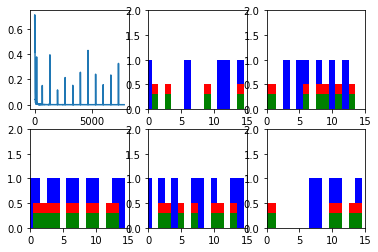

Step 600 Loss 0.000131059


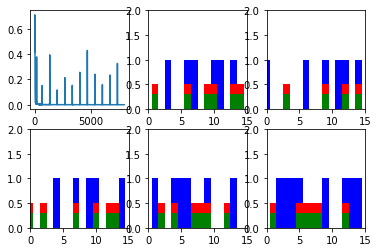

New data, epoch 12
Step 0 Loss 0.56939805


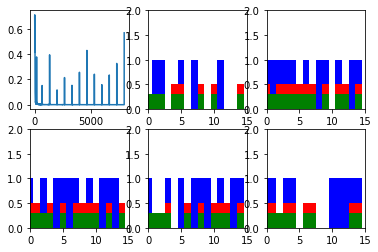

Step 100 Loss 0.00014214417


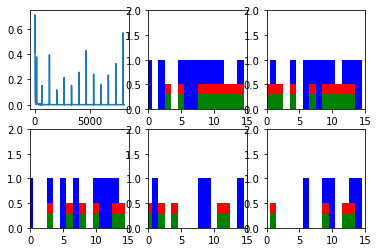

Step 200 Loss 0.00010522907


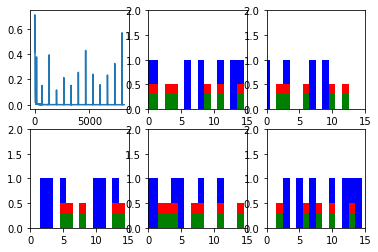

Step 300 Loss 0.00014844668


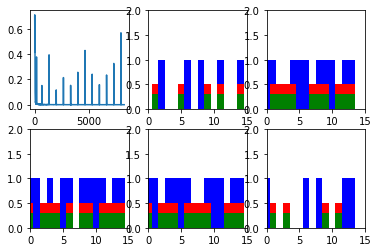

Step 400 Loss 0.00013075993


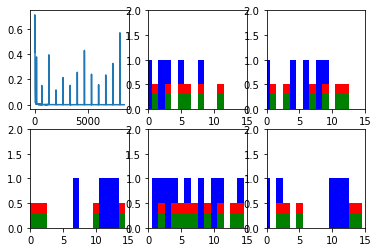

Step 500 Loss 0.000115495735


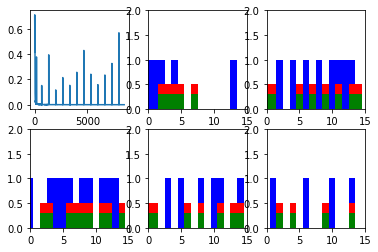

Step 600 Loss 0.00012718976


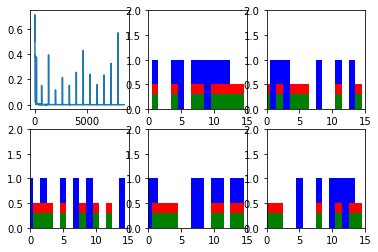

New data, epoch 13
Step 0 Loss 0.2304152


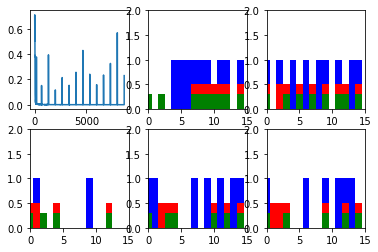

Step 100 Loss 0.0001468133


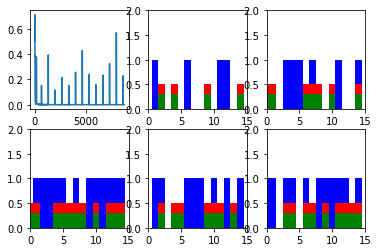

Step 200 Loss 0.00013610053


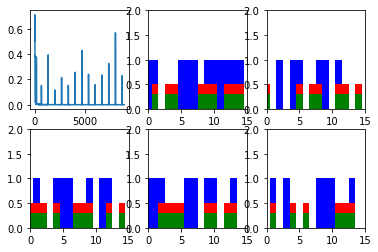

Step 300 Loss 0.00014839655


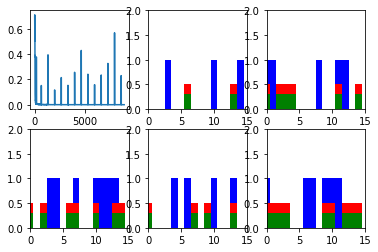

Step 400 Loss 0.00011869021


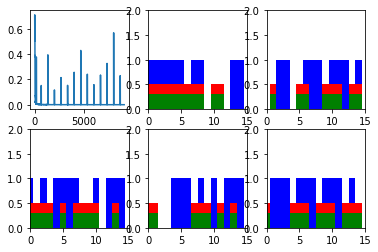

Step 500 Loss 0.00013058132


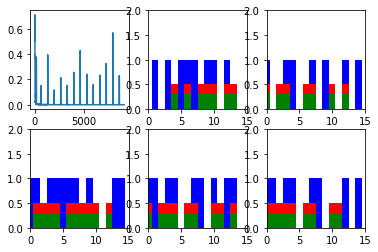

Step 600 Loss 0.000116928444


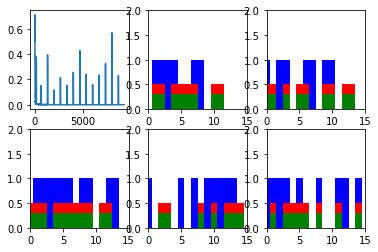

New data, epoch 14
Step 0 Loss 0.43813437


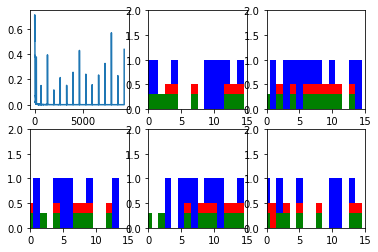

Step 100 Loss 0.00015788985


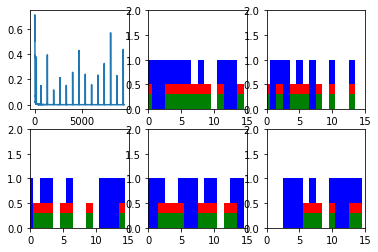

Step 200 Loss 0.00015327625


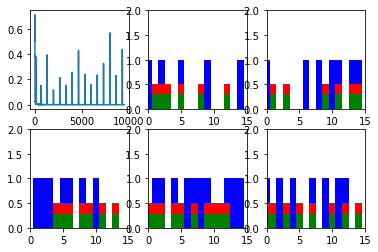

Step 300 Loss 0.00012214221


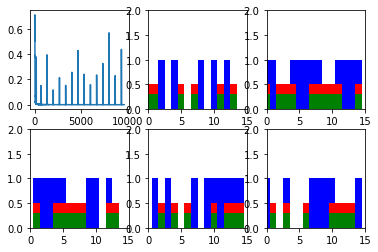

Step 400 Loss 0.00010949075


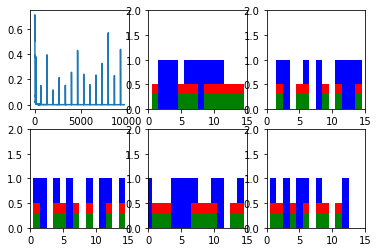

Step 500 Loss 0.000115712384


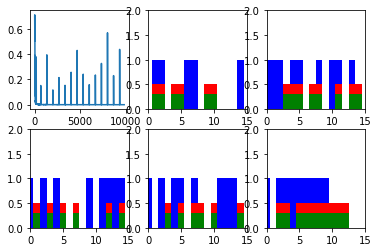

Step 600 Loss 9.055587e-05


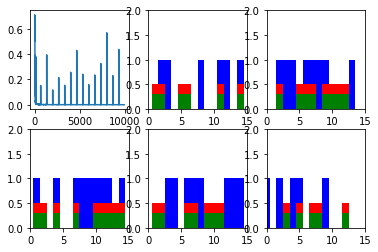

New data, epoch 15
Step 0 Loss 0.38702154


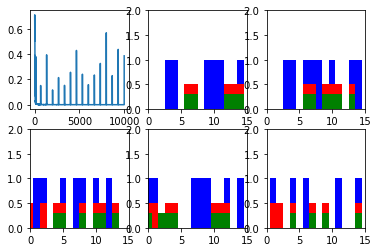

Step 100 Loss 8.97052e-05


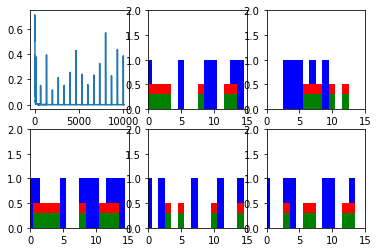

Step 200 Loss 8.702542e-05


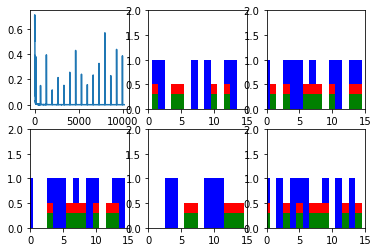

Step 300 Loss 0.000103681195


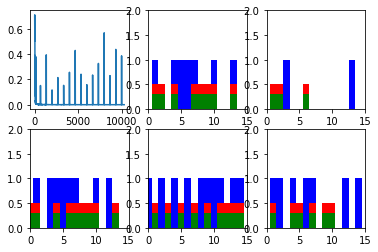

Step 400 Loss 9.1620415e-05


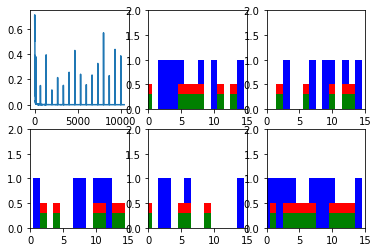

Step 500 Loss 6.9231304e-05


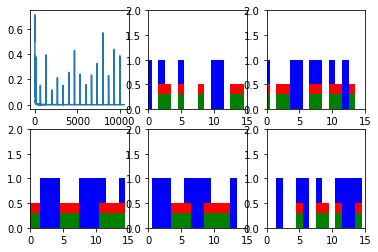

Step 600 Loss 9.178152e-05


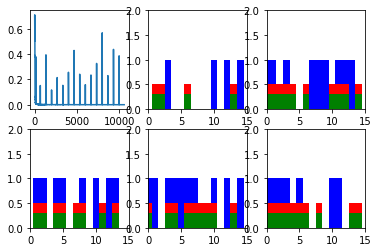

New data, epoch 16
Step 0 Loss 0.18606181


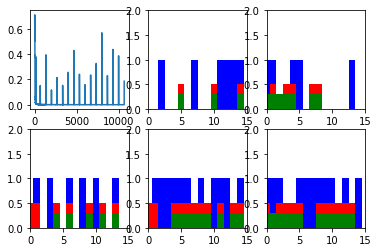

Step 100 Loss 9.198912e-05


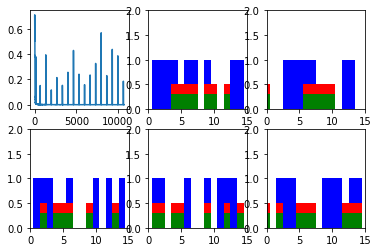

Step 200 Loss 9.413579e-05


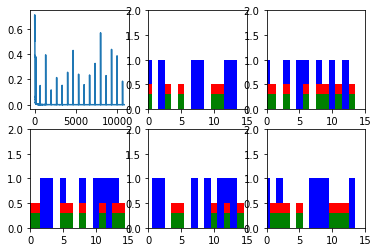

Step 300 Loss 8.587715e-05


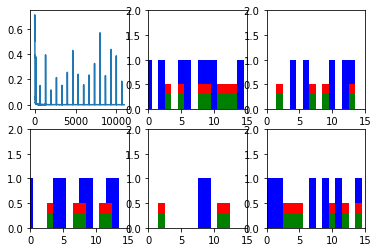

Step 400 Loss 9.597168e-05


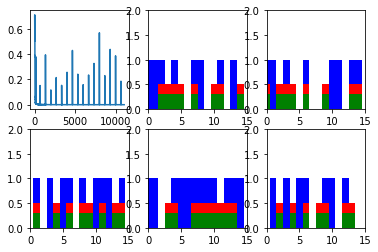

Step 500 Loss 0.00010871191


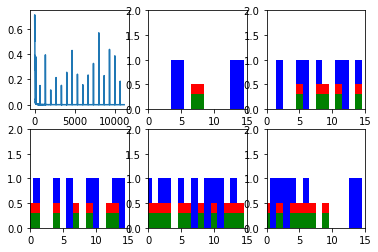

Step 600 Loss 8.89896e-05


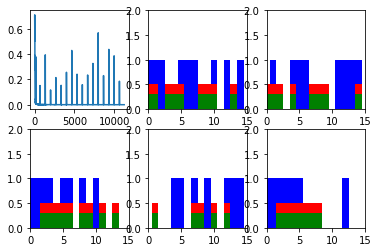

New data, epoch 17
Step 0 Loss 0.16330035


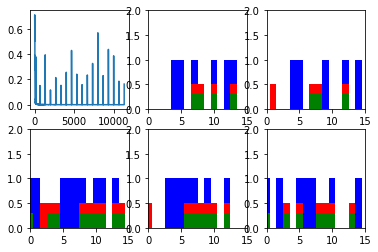

Step 100 Loss 0.00010738857


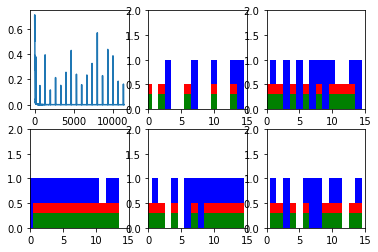

Step 200 Loss 9.1690534e-05


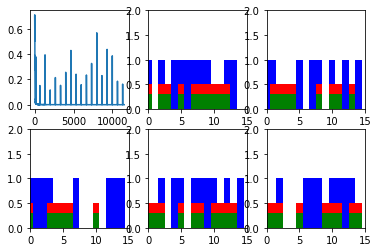

Step 300 Loss 8.744978e-05


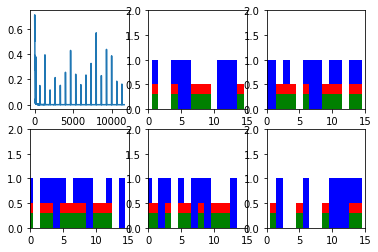

Step 400 Loss 9.423361e-05


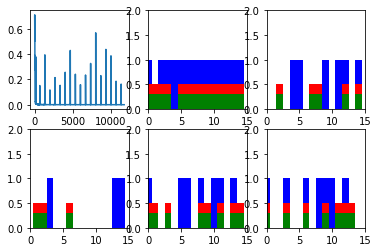

Step 500 Loss 9.08644e-05


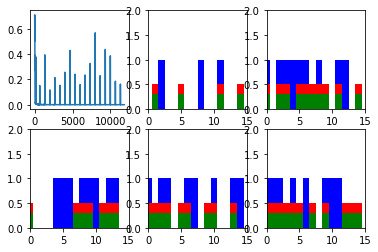

Step 600 Loss 7.7074765e-05


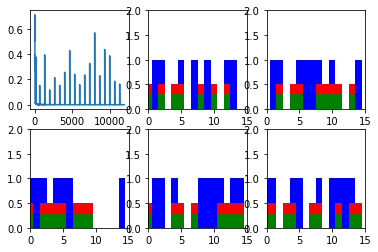

New data, epoch 18
Step 0 Loss 0.15794377


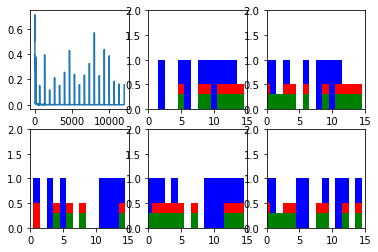

Step 100 Loss 8.988769e-05


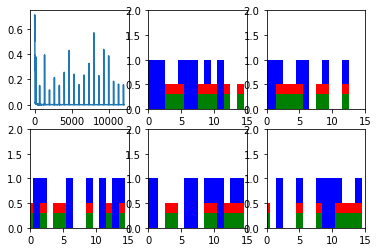

Step 200 Loss 0.000105293046


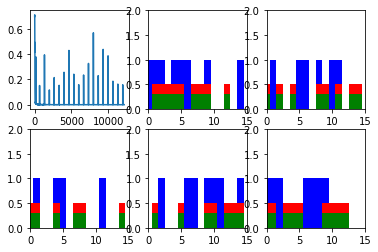

Step 300 Loss 9.0536734e-05


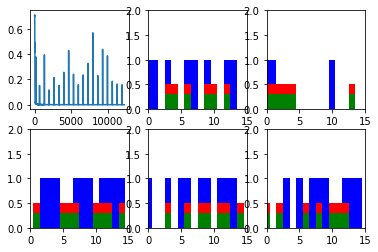

Step 400 Loss 8.9812114e-05


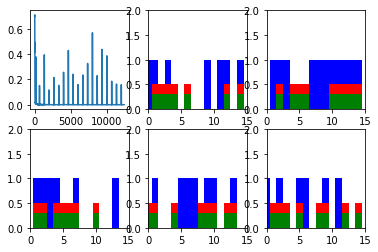

Step 500 Loss 7.1184775e-05


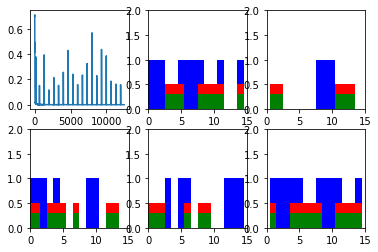

Step 600 Loss 9.3409464e-05


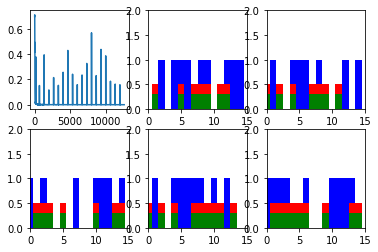

New data, epoch 19
Step 0 Loss 0.32232207


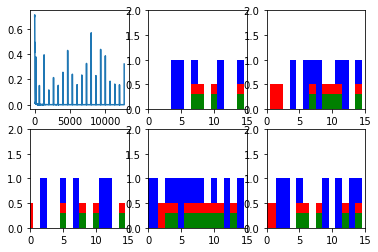

Step 100 Loss 9.126863e-05


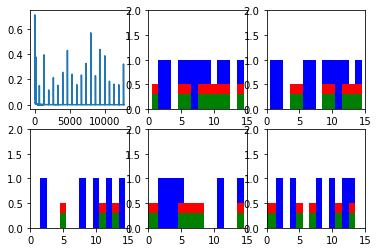

Step 200 Loss 9.5913456e-05


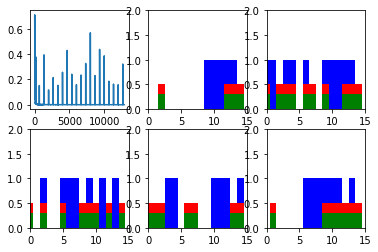

Step 300 Loss 8.7263375e-05


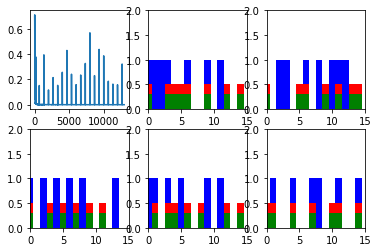

Step 400 Loss 7.51517e-05


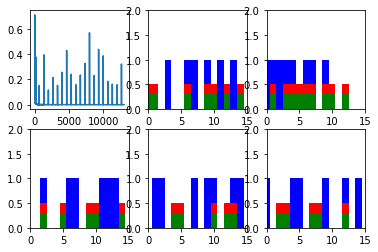

Step 500 Loss 8.377896e-05


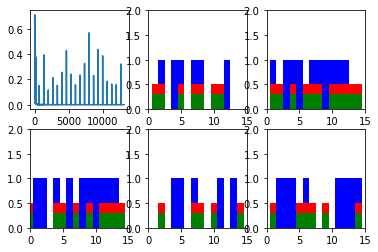

Step 600 Loss 7.816603e-05


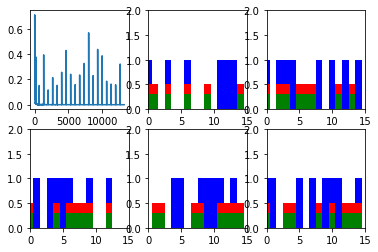

In [17]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

## LSTM
https://medium.com/@erikhallstrm/using-the-tensorflow-lstm-api-3-7-5f2b97ca6b73

In [18]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

In [19]:
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

In [20]:
W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [21]:
# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length,1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [23]:
# Forward passes
cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, state_is_tuple=True)
states_series, current_state = tf.nn.static_rnn(cell, inputs_series, init_state)

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Batch loss 0.69308263


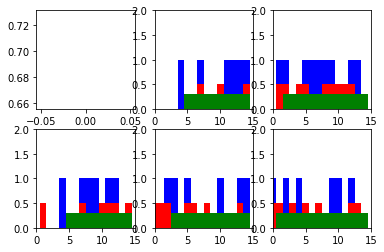

Step 100 Batch loss 0.5740948


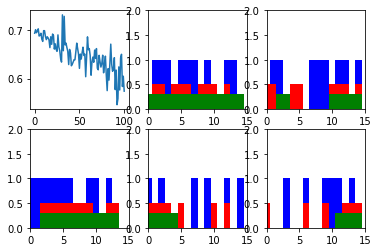

Step 200 Batch loss 0.5479877


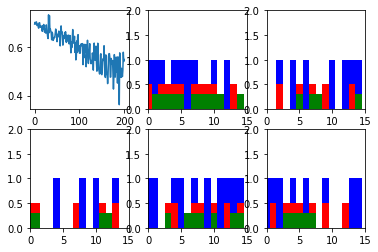

Step 300 Batch loss 0.09256464


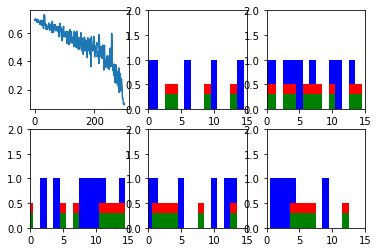

Step 400 Batch loss 0.023889415


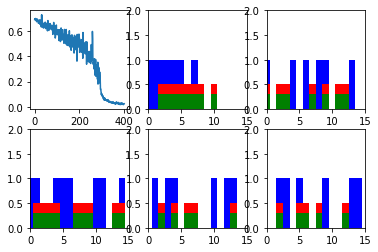

Step 500 Batch loss 0.013113284


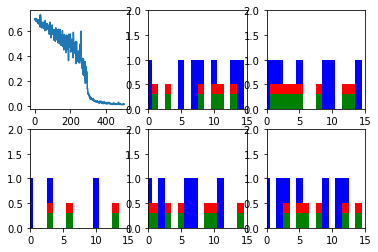

Step 600 Batch loss 0.007990479


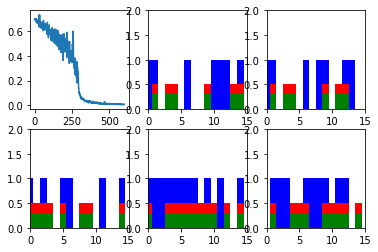

New data, epoch 1
Step 0 Batch loss 0.47455165


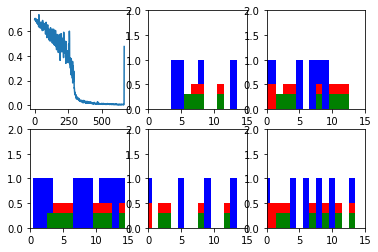

Step 100 Batch loss 0.005530475


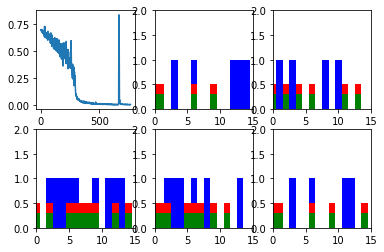

Step 200 Batch loss 0.004880399


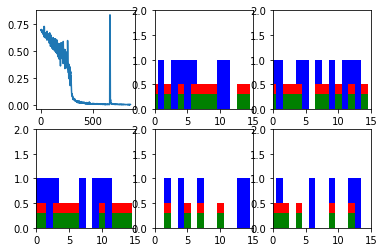

Step 300 Batch loss 0.003307631


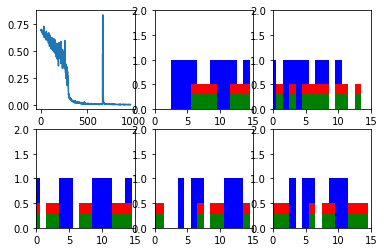

Step 400 Batch loss 0.0030651344


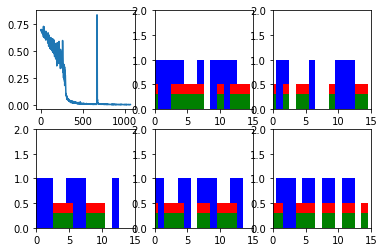

Step 500 Batch loss 0.002255631


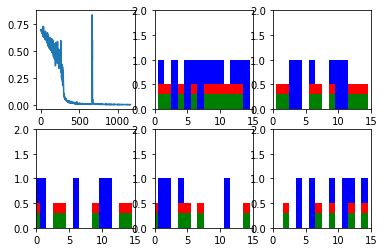

Step 600 Batch loss 0.0020037685


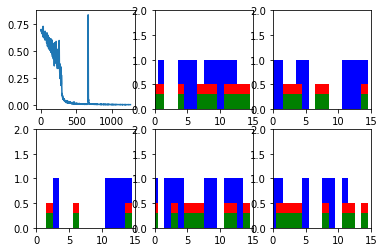

New data, epoch 2
Step 0 Batch loss 0.900985


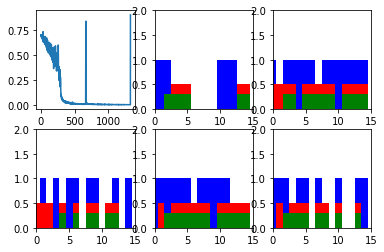

Step 100 Batch loss 0.0017243241


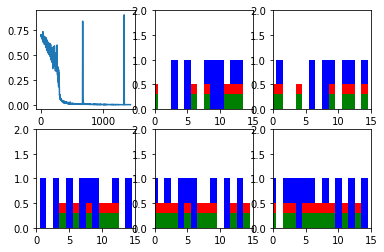

Step 200 Batch loss 0.0014562543


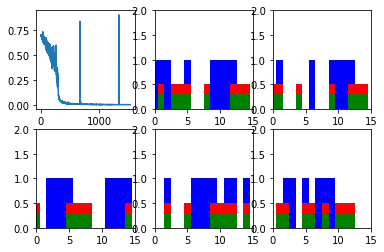

Step 300 Batch loss 0.0015029077


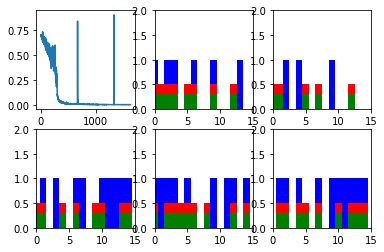

Step 400 Batch loss 0.0014899417


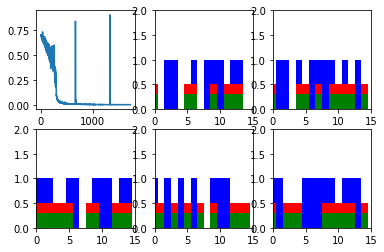

Step 500 Batch loss 0.0010047215


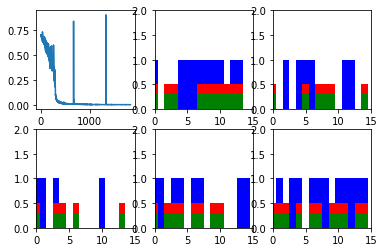

Step 600 Batch loss 0.0011756229


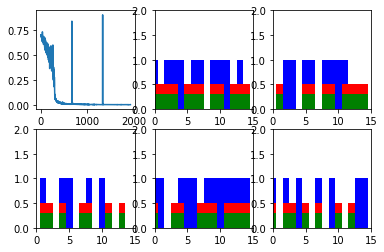

New data, epoch 3
Step 0 Batch loss 0.70176333


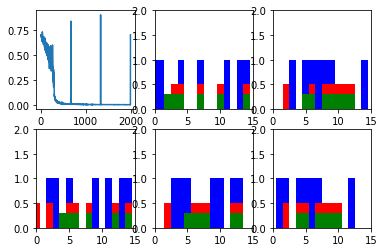

Step 100 Batch loss 0.0013060072


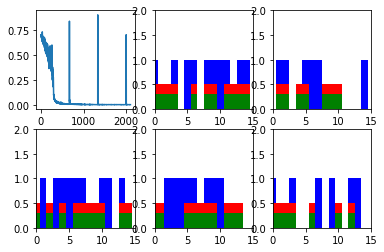

Step 200 Batch loss 0.00081299344


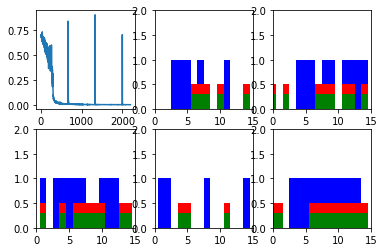

Step 300 Batch loss 0.000978227


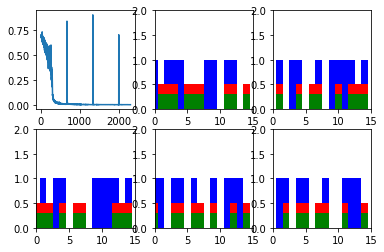

Step 400 Batch loss 0.0011675187


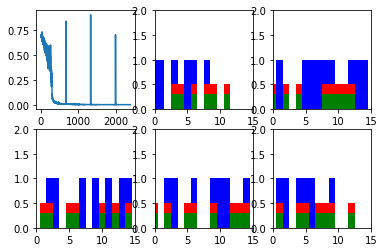

Step 500 Batch loss 0.0007133144


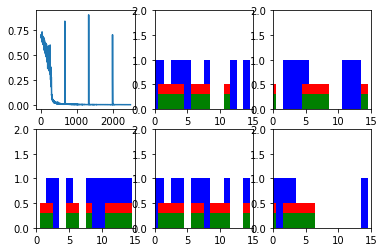

Step 600 Batch loss 0.0007995808


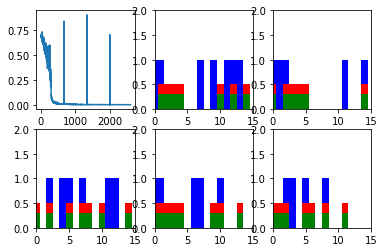

New data, epoch 4
Step 0 Batch loss 0.5927401


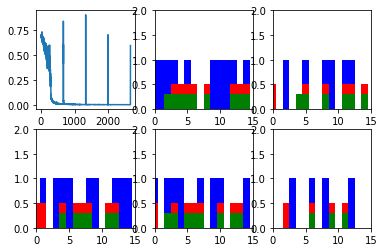

Step 100 Batch loss 0.00066489616


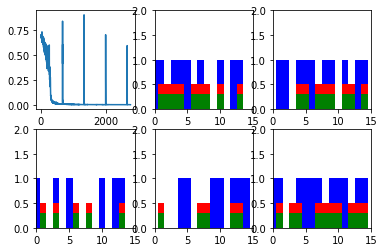

Step 200 Batch loss 0.00058677635


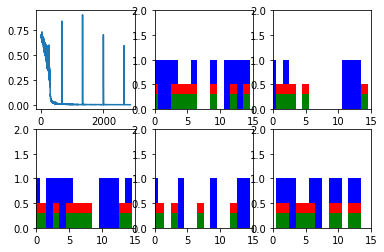

Step 300 Batch loss 0.0006112889


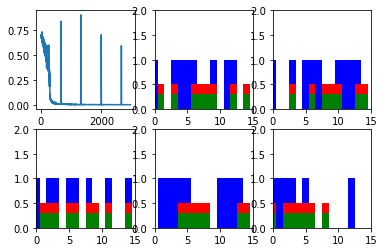

Step 400 Batch loss 0.0009566307


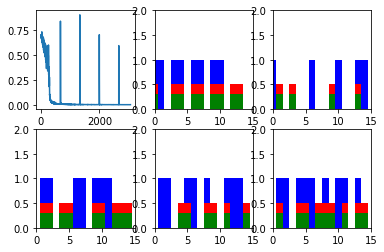

Step 500 Batch loss 0.0005825069


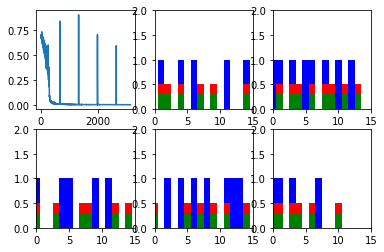

Step 600 Batch loss 0.0004714114


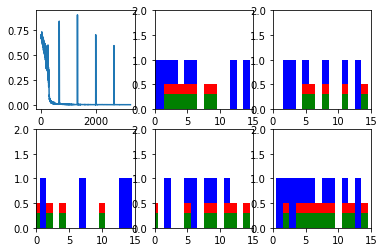

New data, epoch 5
Step 0 Batch loss 0.5807799


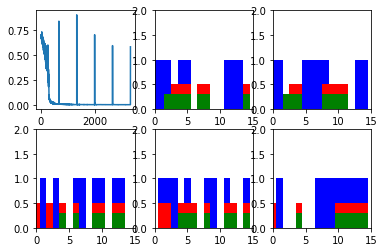

Step 100 Batch loss 0.00074211153


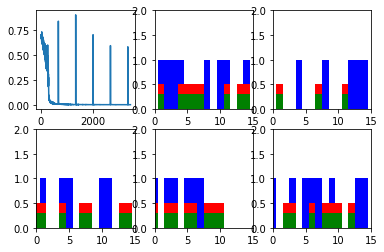

Step 200 Batch loss 0.0005493958


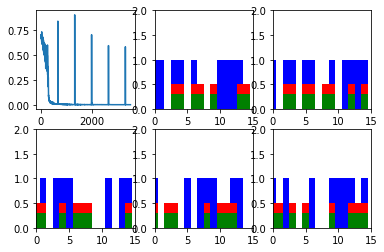

Step 300 Batch loss 0.00051210023


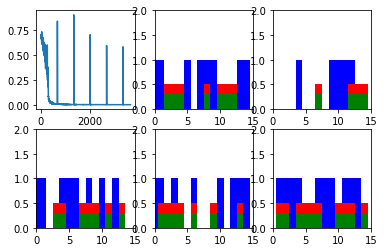

Step 400 Batch loss 0.00052385713


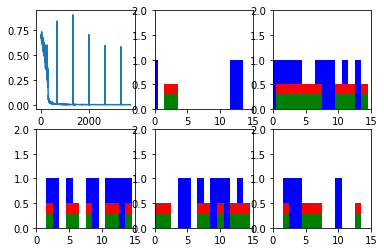

Step 500 Batch loss 0.00047664504


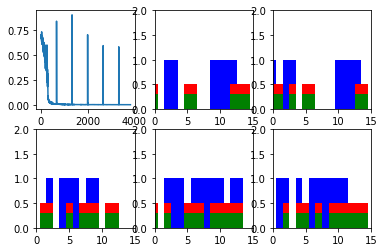

Step 600 Batch loss 0.000458911


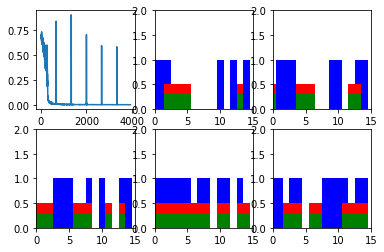

New data, epoch 6
Step 0 Batch loss 0.43799642


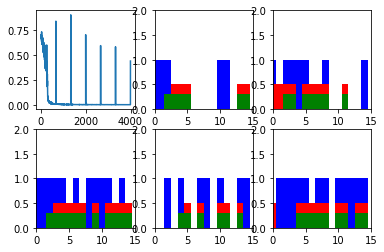

Step 100 Batch loss 0.00057161227


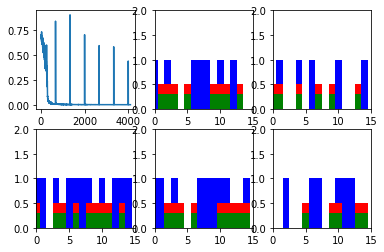

Step 200 Batch loss 0.00044315468


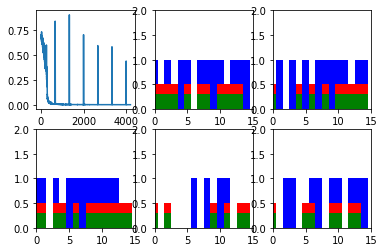

Step 300 Batch loss 0.000557181


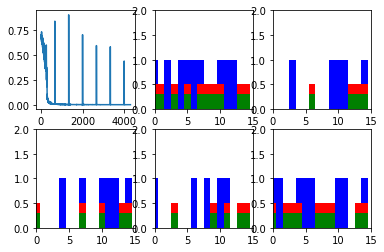

Step 400 Batch loss 0.00046680553


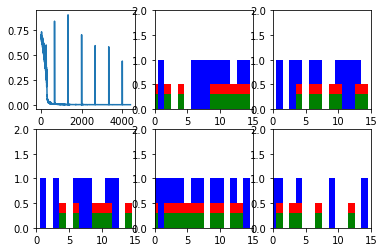

Step 500 Batch loss 0.00041200794


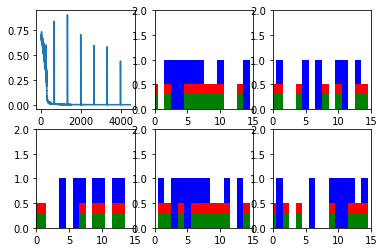

Step 600 Batch loss 0.00037649006


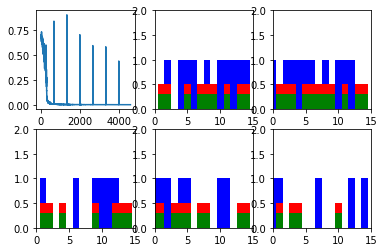

New data, epoch 7
Step 0 Batch loss 0.839055


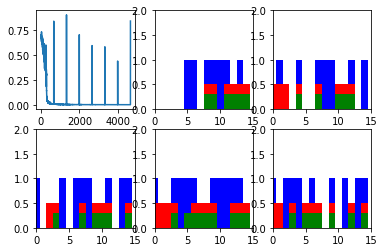

Step 100 Batch loss 0.00029412046


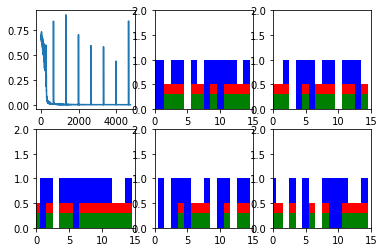

Step 200 Batch loss 0.00031541998


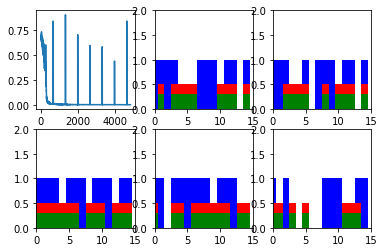

Step 300 Batch loss 0.00049506663


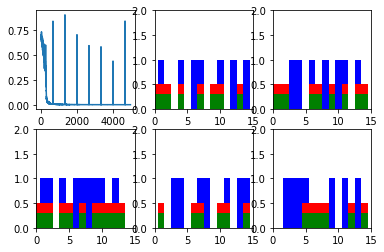

Step 400 Batch loss 0.00031525813


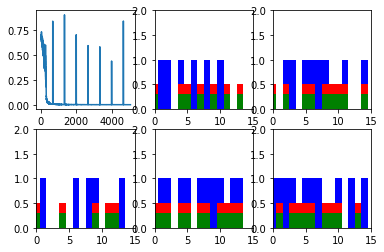

Step 500 Batch loss 0.00037317592


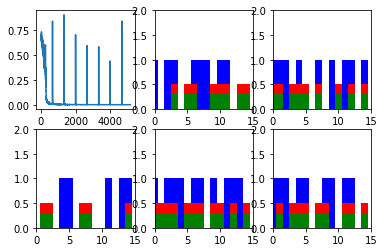

Step 600 Batch loss 0.0003230826


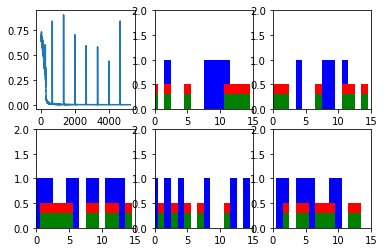

New data, epoch 8
Step 0 Batch loss 0.5460883


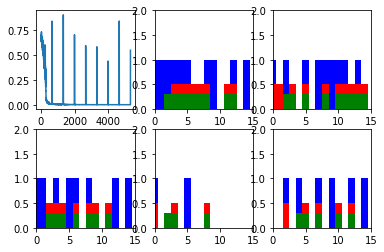

Step 100 Batch loss 0.00031723242


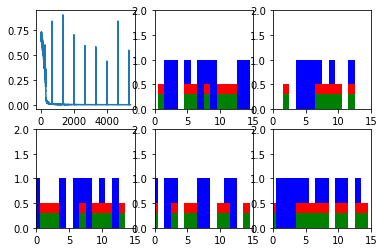

Step 200 Batch loss 0.00043820654


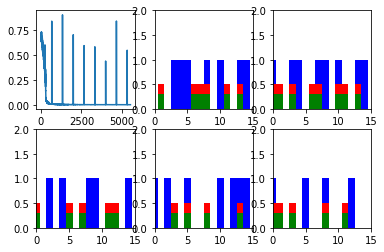

Step 300 Batch loss 0.0002893388


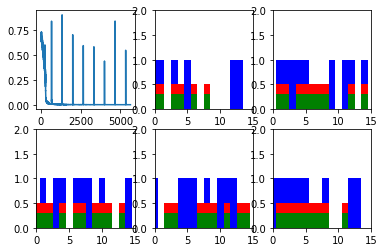

Step 400 Batch loss 0.00028647718


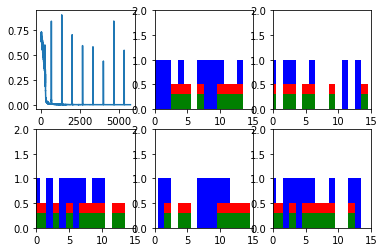

Step 500 Batch loss 0.00030241735


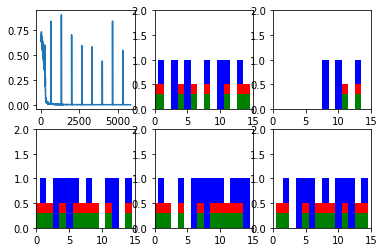

Step 600 Batch loss 0.00038411538


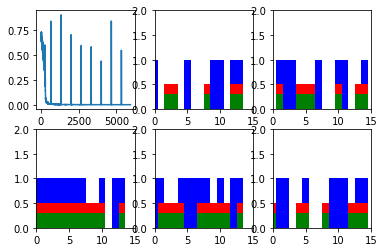

New data, epoch 9
Step 0 Batch loss 0.70026326


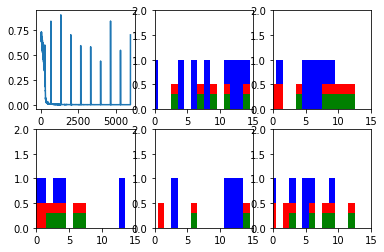

Step 100 Batch loss 0.00028915523


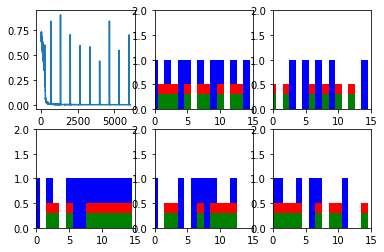

Step 200 Batch loss 0.00030398692


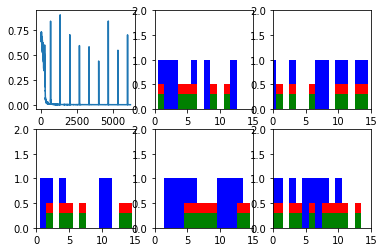

Step 300 Batch loss 0.00028282497


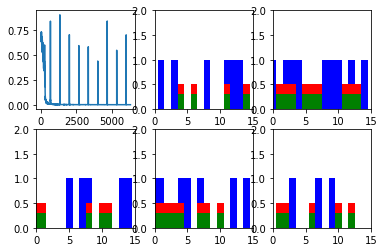

Step 400 Batch loss 0.00030019667


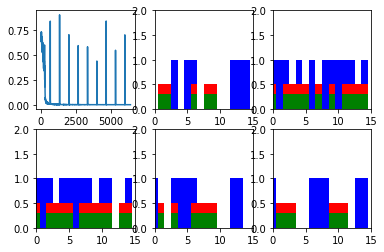

Step 500 Batch loss 0.00034289065


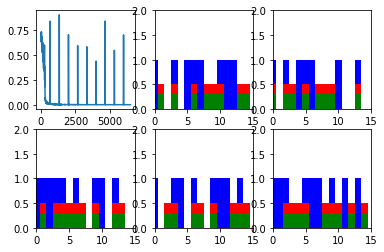

Step 600 Batch loss 0.00024168826


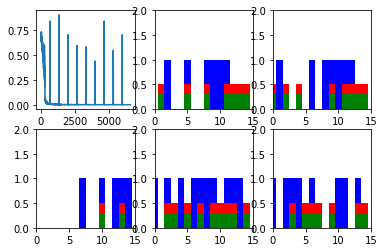

New data, epoch 10
Step 0 Batch loss 1.0750598


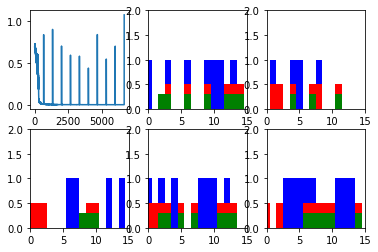

Step 100 Batch loss 0.00035293392


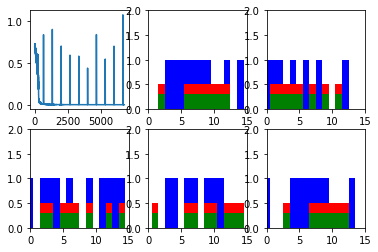

Step 200 Batch loss 0.0003921036


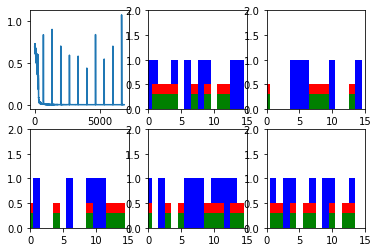

Step 300 Batch loss 0.00047222842


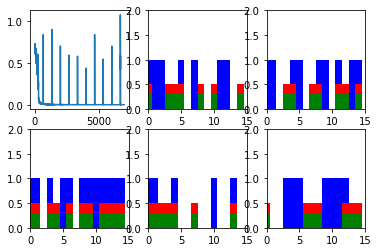

Step 400 Batch loss 0.00044746776


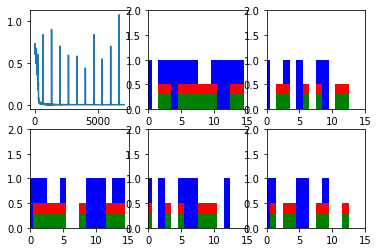

Step 500 Batch loss 0.00046427405


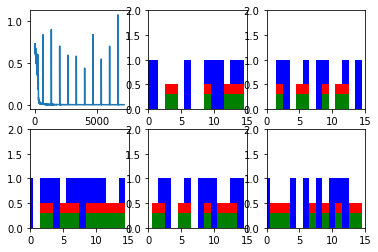

Step 600 Batch loss 0.00033717812


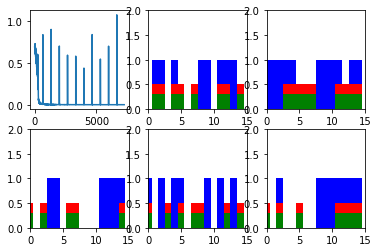

New data, epoch 11
Step 0 Batch loss 0.27755404


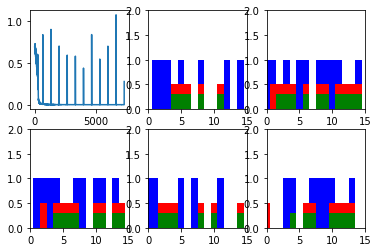

Step 100 Batch loss 0.00033841887


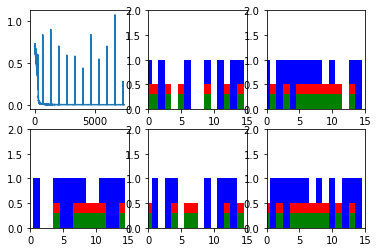

Step 200 Batch loss 0.00037957338


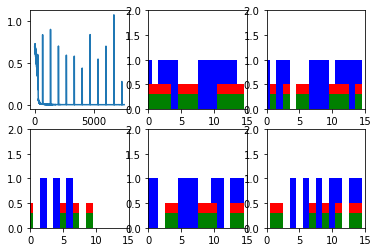

Step 300 Batch loss 0.00037384525


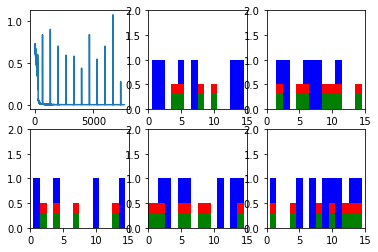

Step 400 Batch loss 0.00032976523


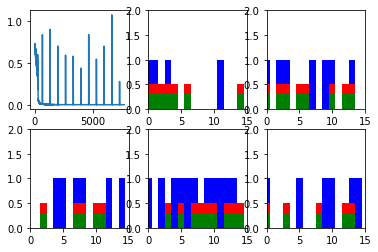

Step 500 Batch loss 0.0002584302


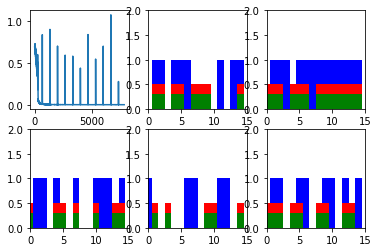

Step 600 Batch loss 0.0003192407


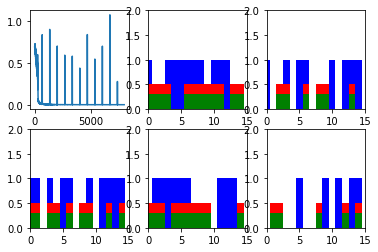

New data, epoch 12
Step 0 Batch loss 0.45708573


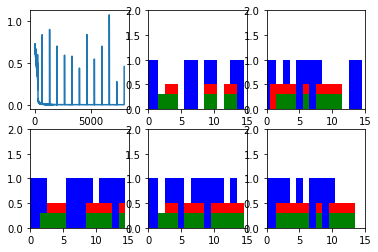

Step 100 Batch loss 0.00023744849


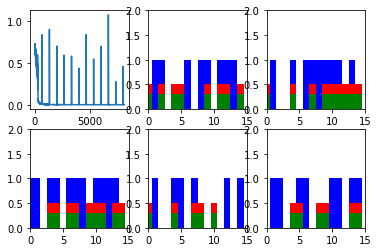

Step 200 Batch loss 0.0003030932


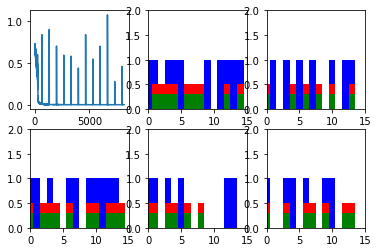

Step 300 Batch loss 0.0002987323


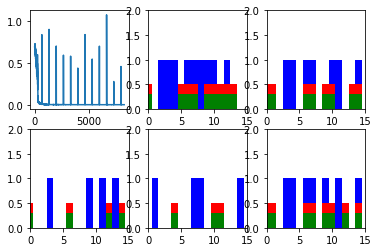

Step 400 Batch loss 0.00024694984


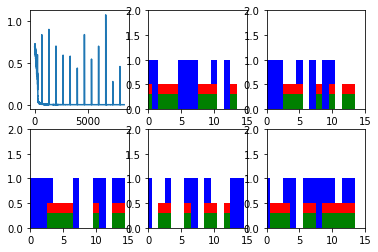

Step 500 Batch loss 0.00022848482


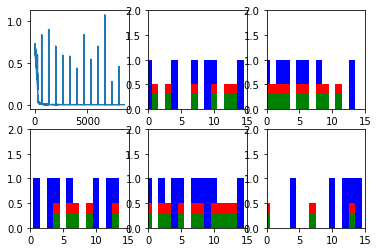

Step 600 Batch loss 0.00030943842


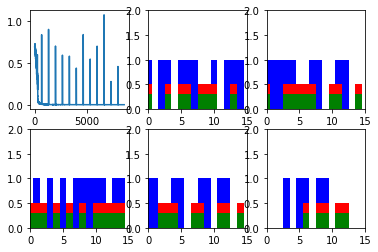

New data, epoch 13
Step 0 Batch loss 1.1079967


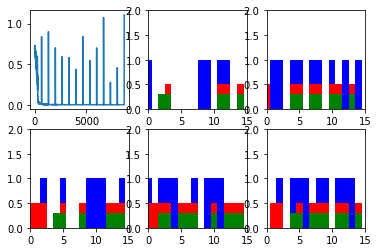

Step 100 Batch loss 0.00023018268


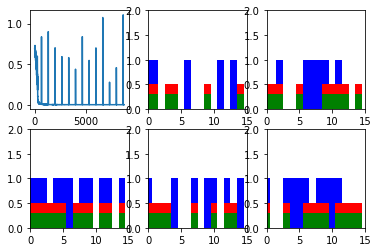

Step 200 Batch loss 0.00031940022


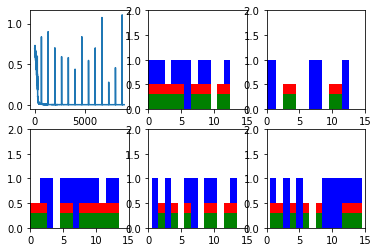

Step 300 Batch loss 0.0003810525


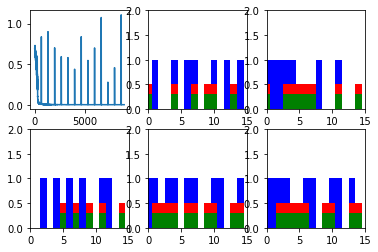

Step 400 Batch loss 0.00023887785


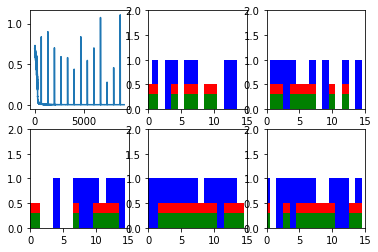

Step 500 Batch loss 0.00029132614


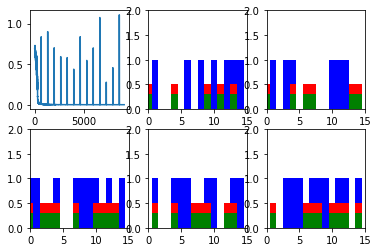

Step 600 Batch loss 0.0002699033


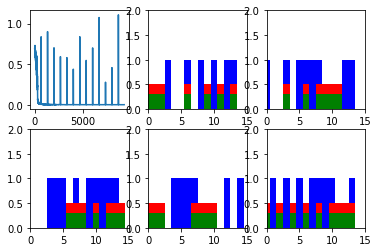

New data, epoch 14
Step 0 Batch loss 0.5251927


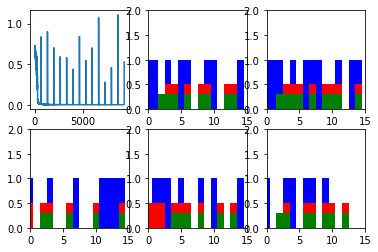

Step 100 Batch loss 0.00022314918


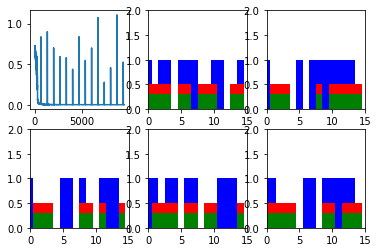

Step 200 Batch loss 0.00025014437


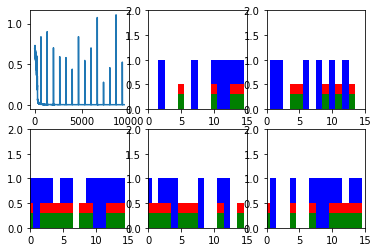

Step 300 Batch loss 0.00021712527


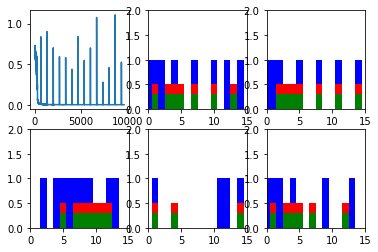

Step 400 Batch loss 0.00025150322


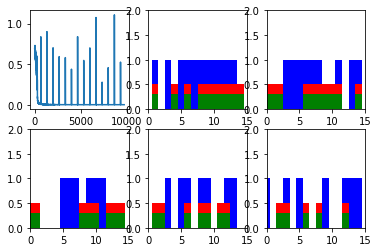

Step 500 Batch loss 0.000255053


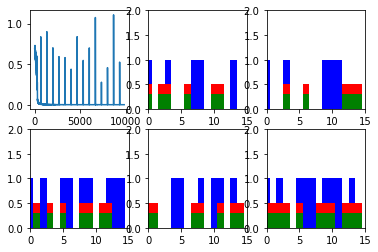

Step 600 Batch loss 0.00028761744


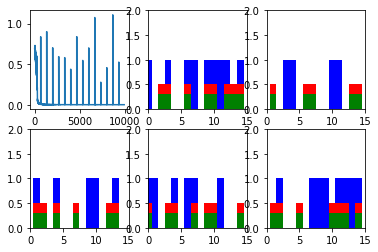

New data, epoch 15
Step 0 Batch loss 0.85371715


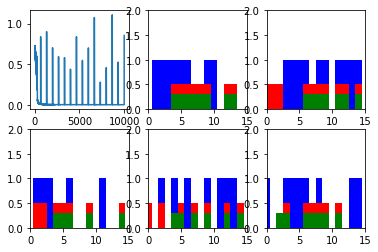

Step 100 Batch loss 0.0002231724


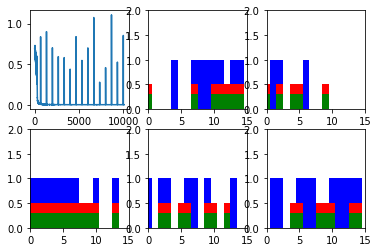

Step 200 Batch loss 0.00036116407


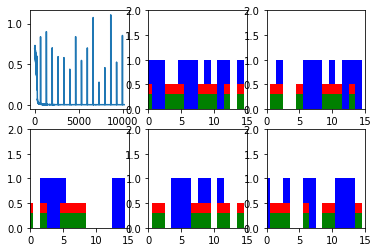

Step 300 Batch loss 0.00022946882


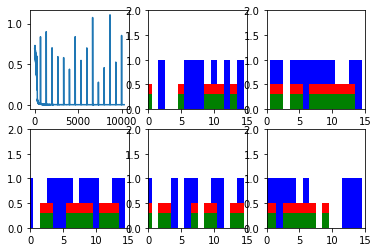

Step 400 Batch loss 0.00023825395


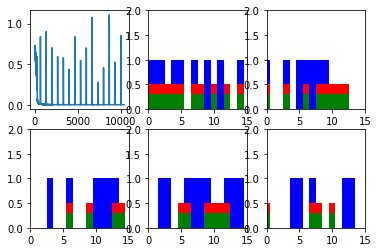

Step 500 Batch loss 0.00017456748


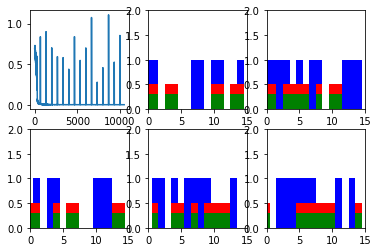

Step 600 Batch loss 0.00019002012


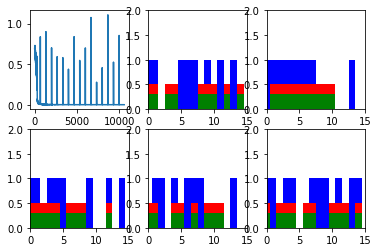

New data, epoch 16
Step 0 Batch loss 1.2364419


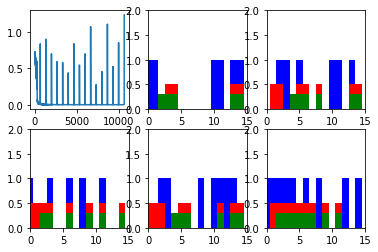

Step 100 Batch loss 0.00022184683


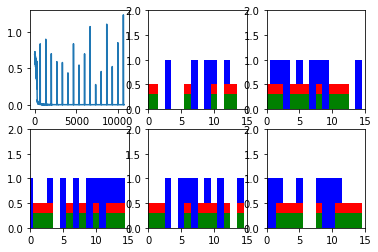

Step 200 Batch loss 0.00022059912


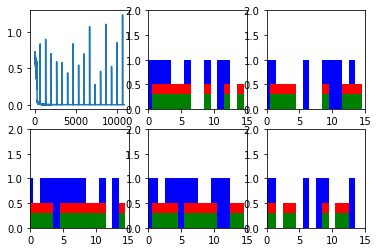

Step 300 Batch loss 0.00022933568


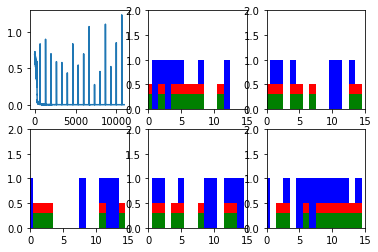

Step 400 Batch loss 0.000319852


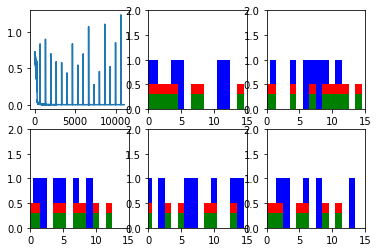

Step 500 Batch loss 0.00032730534


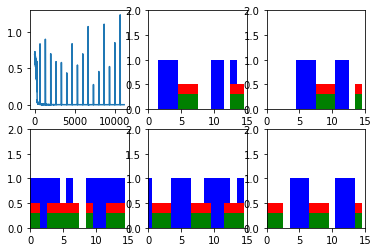

Step 600 Batch loss 0.00019379245


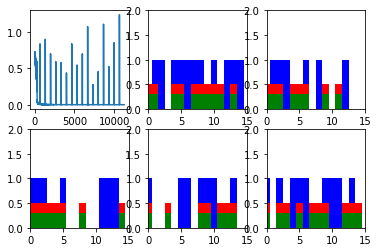

New data, epoch 17
Step 0 Batch loss 1.0195975


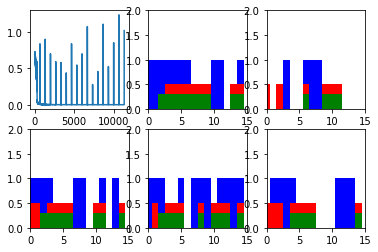

Step 100 Batch loss 0.00022434742


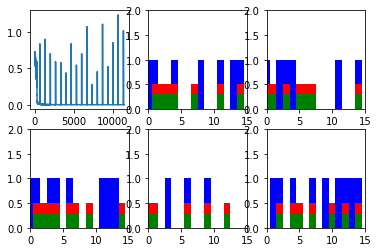

Step 200 Batch loss 0.00023454311


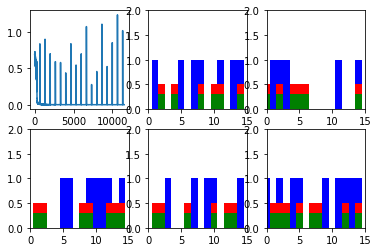

Step 300 Batch loss 0.00021691006


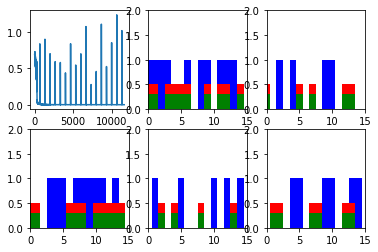

Step 400 Batch loss 0.00023509815


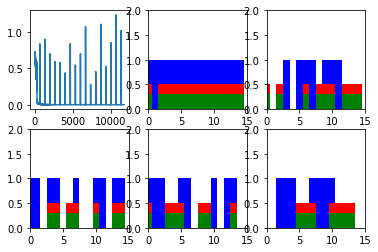

Step 500 Batch loss 0.0002457771


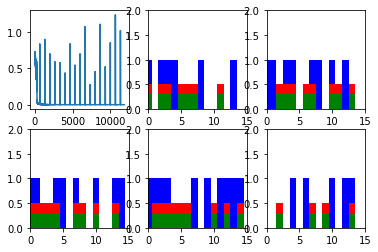

Step 600 Batch loss 0.00017381085


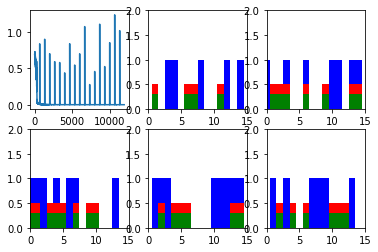

New data, epoch 18
Step 0 Batch loss 0.5653013


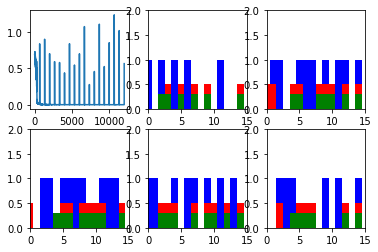

Step 100 Batch loss 0.00020220432


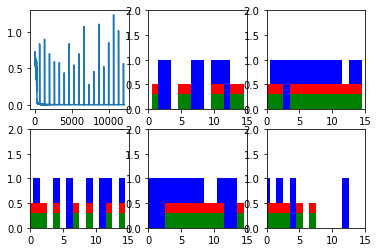

Step 200 Batch loss 0.00023946866


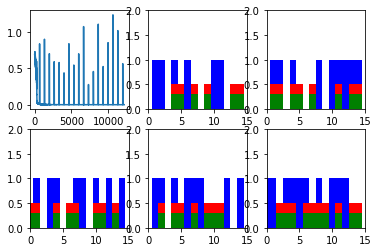

Step 300 Batch loss 0.0002053471


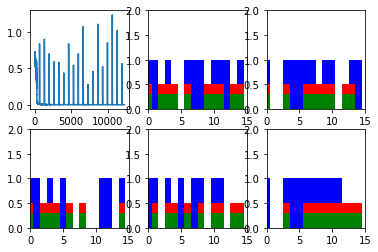

Step 400 Batch loss 0.00016366476


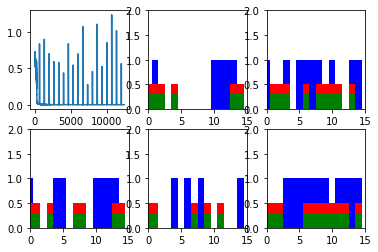

Step 500 Batch loss 0.00022538993


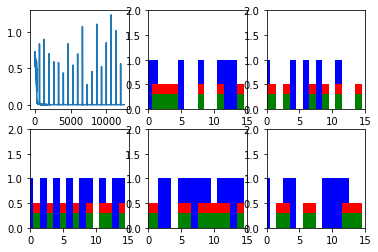

Step 600 Batch loss 0.00018603388


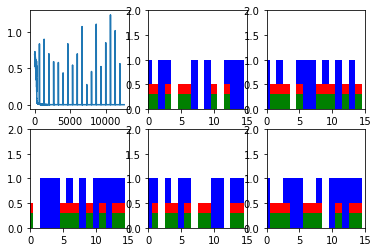

New data, epoch 19
Step 0 Batch loss 0.31418866


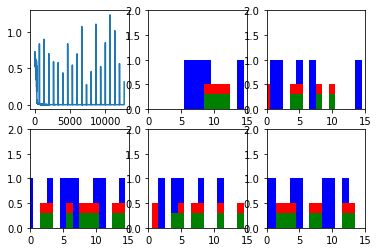

Step 100 Batch loss 0.00031793606


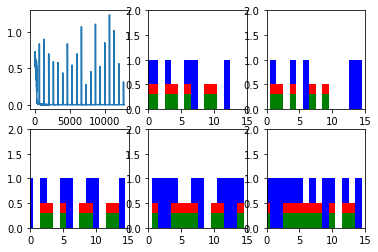

Step 200 Batch loss 0.00021100588


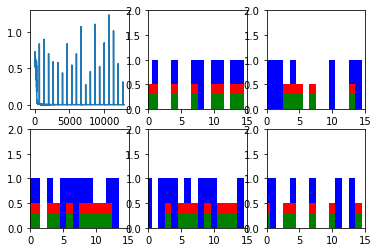

Step 300 Batch loss 0.0002081261


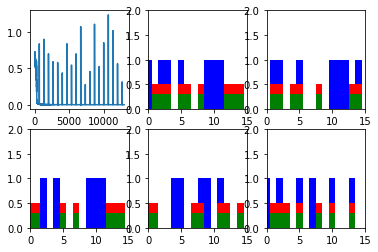

Step 400 Batch loss 0.00015878538


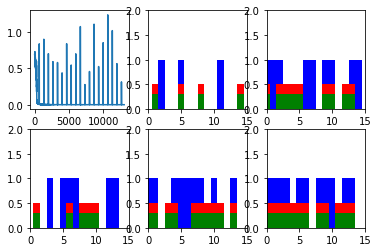

Step 500 Batch loss 0.00018147459


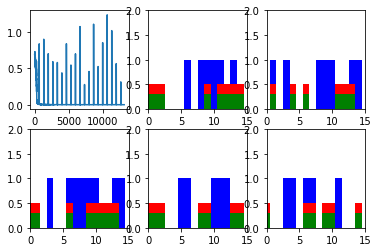

Step 600 Batch loss 0.00018880297


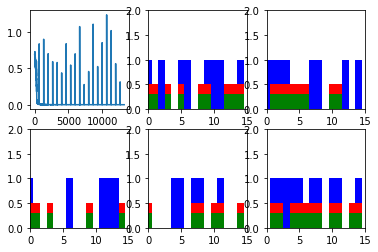

In [24]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_cell_state = np.zeros((batch_size, state_size))
        _current_hidden_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state

                })

            _current_cell_state, _current_hidden_state = _current_state

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

## MultiLayered LSTM

_current_state = np.zeros((num_layers, 2, batch_size, state_size)) #2 = cells and hidden state

_total_loss, _train_step, _current_state, _predictions_series = sess.run(
    [total_loss, train_step, current_state, predictions_series],
    feed_dict={
        batchX_placeholder: batchX,
        batchY_placeholder: batchY,
        init_state: _current_state
    })
    

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])


state_per_layer_list = tf.unpack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

\# Forward passes
cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.nn.rnn(cell, inputs_series, initial_state=rnn_tuple_state)

In [7]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

In [8]:
init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

In [9]:
state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [10]:
# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, 1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [13]:
# Forward passes
cells = []
for l in range(num_layers):
    cells.append(tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True, reuse=True))
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)
states_series, current_state = tf.nn.static_rnn(cell, inputs_series, initial_state=rnn_tuple_state)

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Batch loss 0.6932568


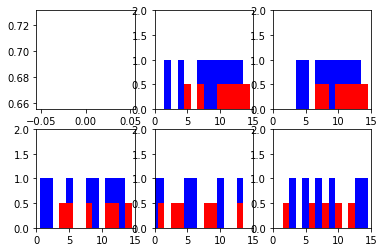

Step 100 Batch loss 0.68839025


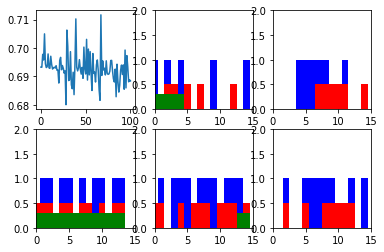

Step 200 Batch loss 0.59013796


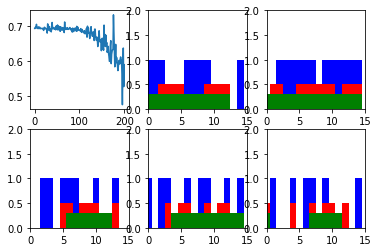

Step 300 Batch loss 0.48798788


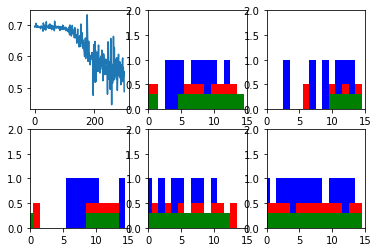

Step 400 Batch loss 0.48281977


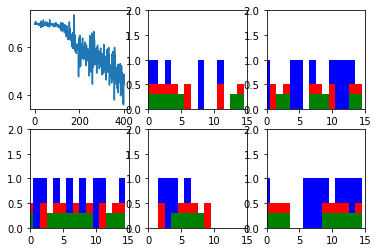

Step 500 Batch loss 0.06706321


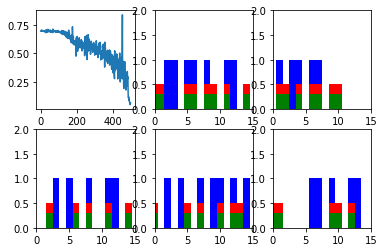

Step 600 Batch loss 0.013845464


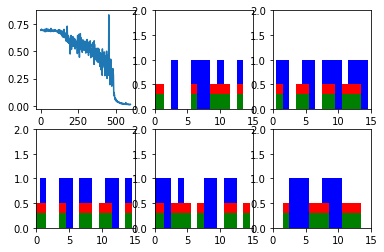

New data, epoch 1
Step 0 Batch loss 0.47437552


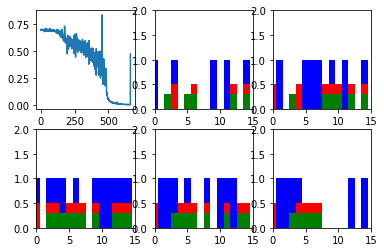

Step 100 Batch loss 0.00432524


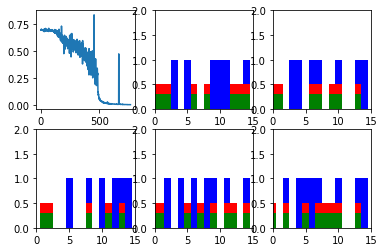

Step 200 Batch loss 0.002864269


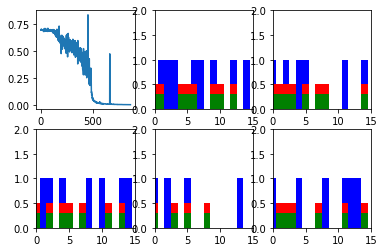

Step 300 Batch loss 0.0021214883


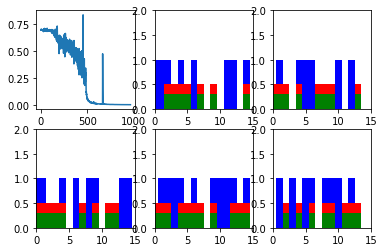

Step 400 Batch loss 0.001675802


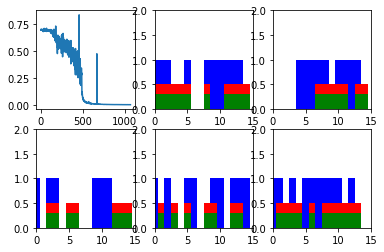

Step 500 Batch loss 0.0015142768


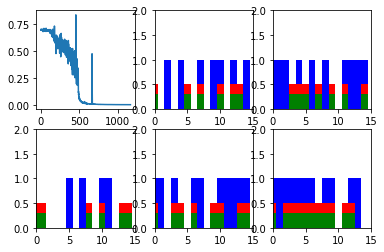

Step 600 Batch loss 0.0012105916


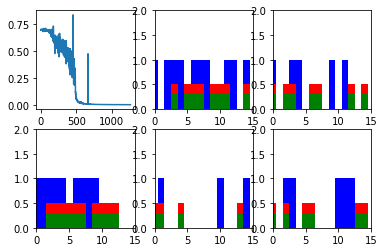

New data, epoch 2
Step 0 Batch loss 0.70432633


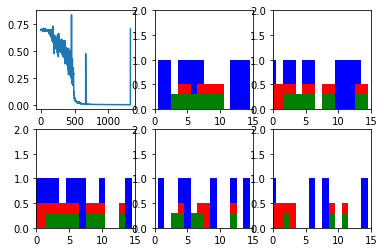

Step 100 Batch loss 0.0029130569


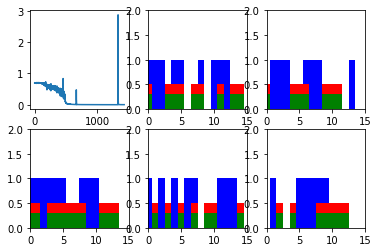

Step 200 Batch loss 0.0020726628


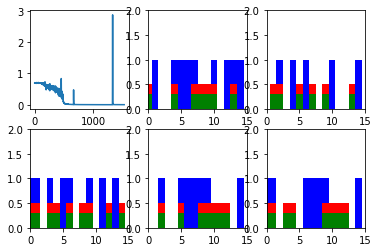

Step 300 Batch loss 0.0015323089


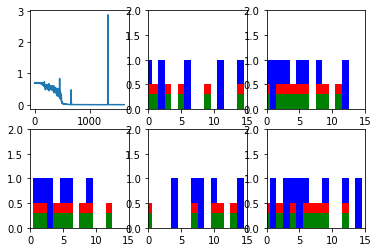

Step 400 Batch loss 0.0015713219


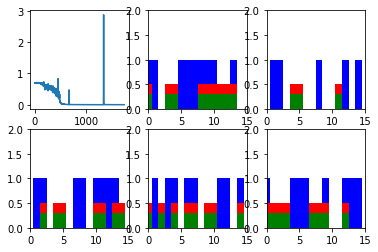

Step 500 Batch loss 0.001054751


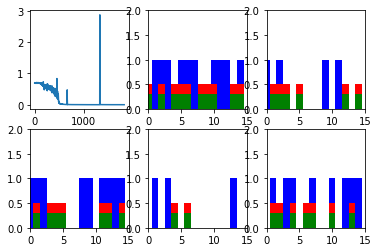

Step 600 Batch loss 0.0010608693


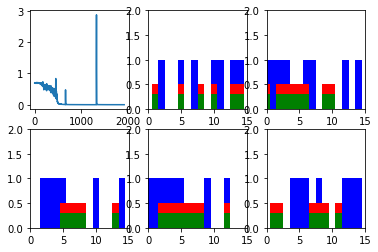

New data, epoch 3
Step 0 Batch loss 0.99548006


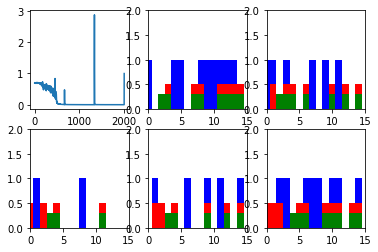

Step 100 Batch loss 0.0010272858


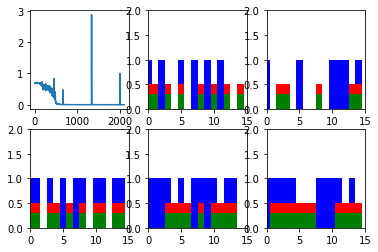

Step 200 Batch loss 0.00090478867


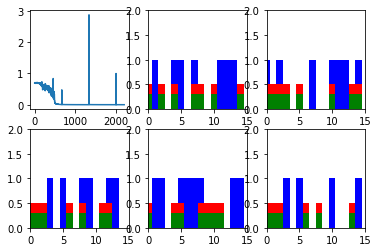

Step 300 Batch loss 0.0008401722


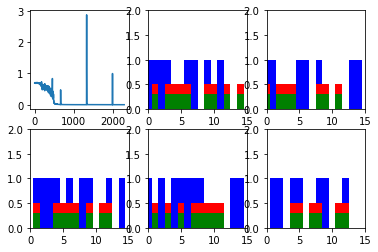

Step 400 Batch loss 0.00079807005


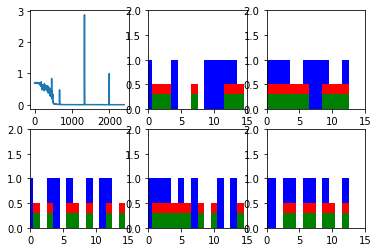

Step 500 Batch loss 0.00065314595


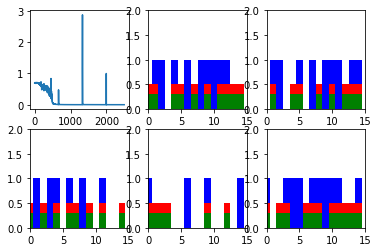

Step 600 Batch loss 0.000578491


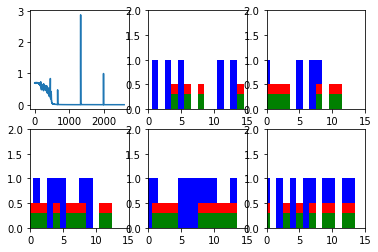

New data, epoch 4
Step 0 Batch loss 0.58743143


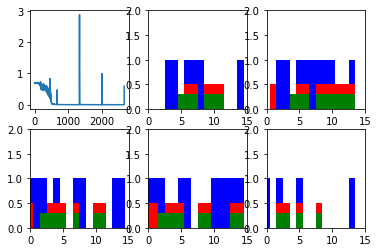

Step 100 Batch loss 0.0006878531


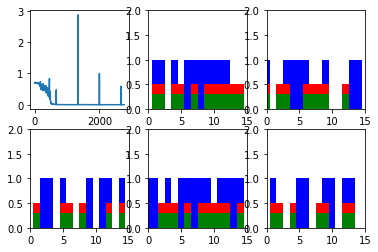

Step 200 Batch loss 0.0006120762


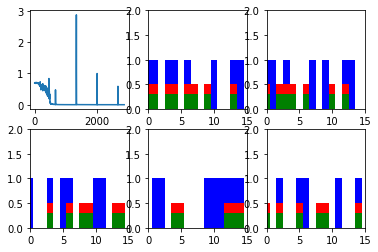

Step 300 Batch loss 0.0005602129


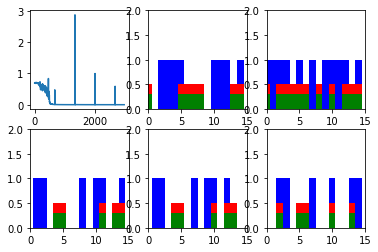

Step 400 Batch loss 0.0005100224


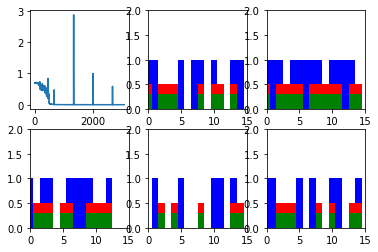

Step 500 Batch loss 0.00042156264


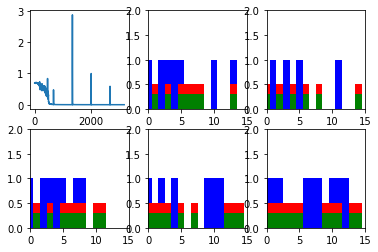

Step 600 Batch loss 0.0004379494


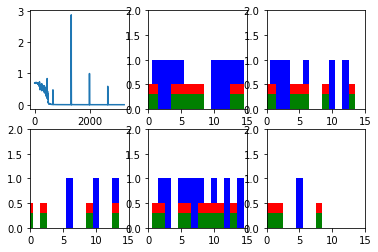

New data, epoch 5
Step 0 Batch loss 0.7926665


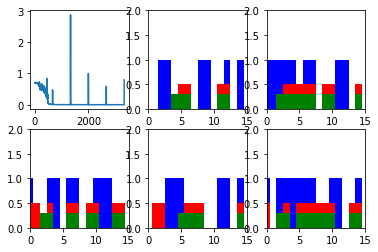

Step 100 Batch loss 0.0005900583


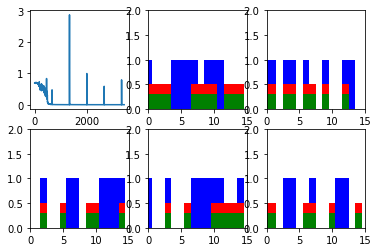

Step 200 Batch loss 0.0004361567


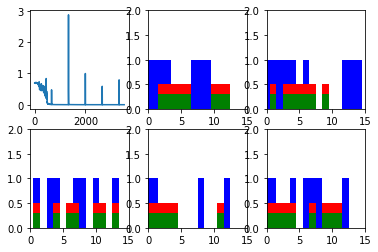

Step 300 Batch loss 0.0004281046


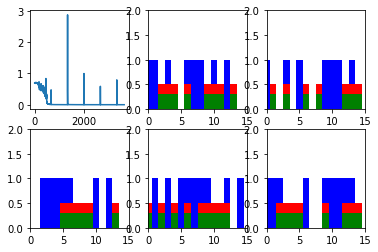

Step 400 Batch loss 0.00038773345


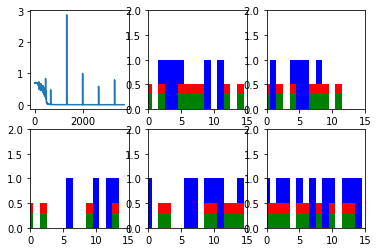

Step 500 Batch loss 0.00042448918


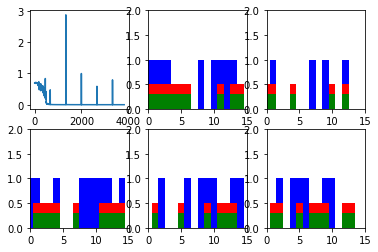

Step 600 Batch loss 0.0003825442


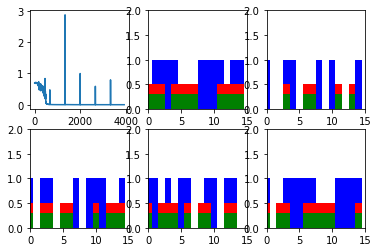

New data, epoch 6
Step 0 Batch loss 0.5242294


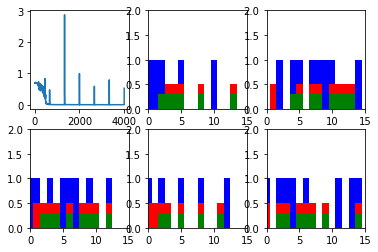

Step 100 Batch loss 0.00038974723


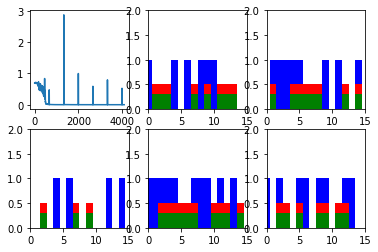

Step 200 Batch loss 0.00037480364


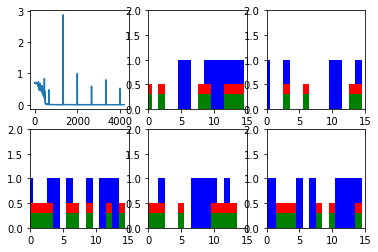

Step 300 Batch loss 0.0003642648


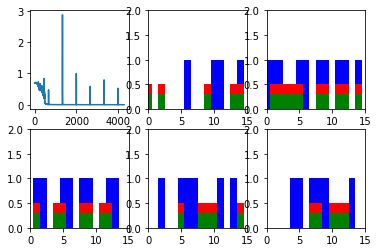

Step 400 Batch loss 0.00033455808


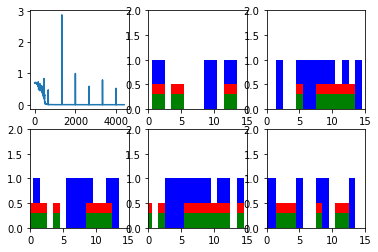

Step 500 Batch loss 0.0002984124


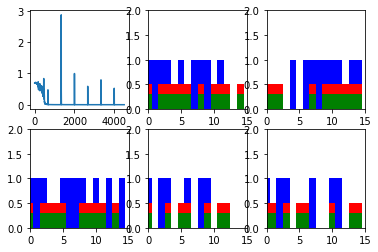

Step 600 Batch loss 0.0002803059


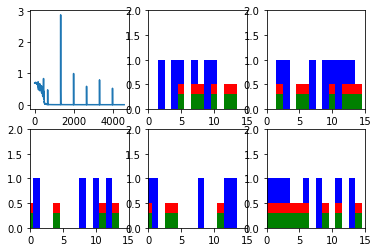

New data, epoch 7
Step 0 Batch loss 0.325301


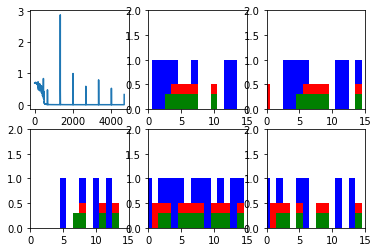

Step 100 Batch loss 0.00054258626


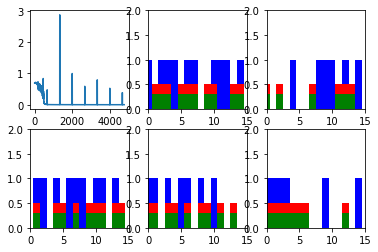

Step 200 Batch loss 0.00039540292


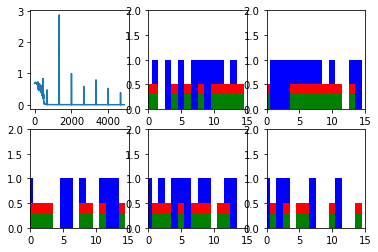

Step 300 Batch loss 0.00037772616


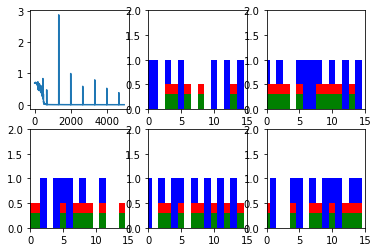

Step 400 Batch loss 0.00035025715


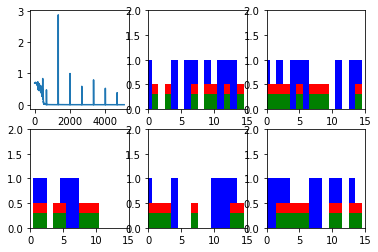

Step 500 Batch loss 0.00033866183


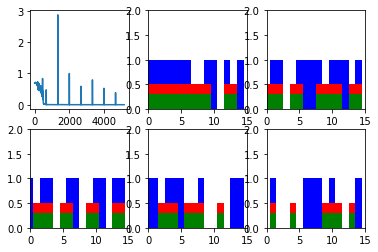

Step 600 Batch loss 0.00031203398


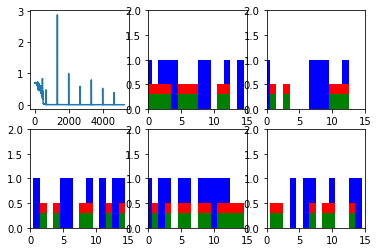

New data, epoch 8
Step 0 Batch loss 0.44868982


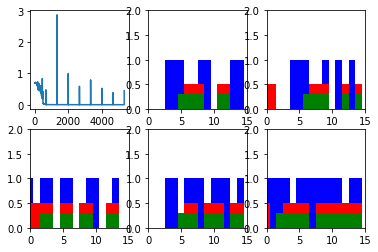

Step 100 Batch loss 0.00033042583


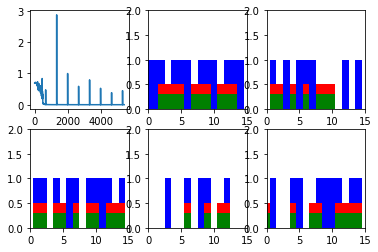

Step 200 Batch loss 0.00032033553


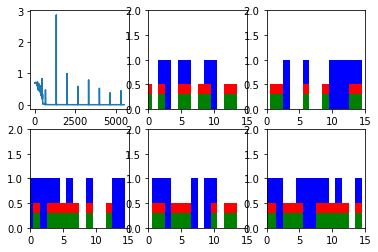

Step 300 Batch loss 0.0002754921


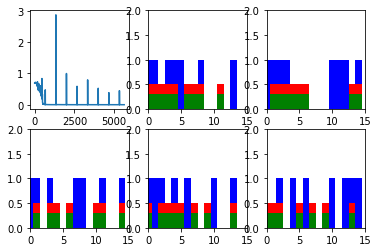

Step 400 Batch loss 0.00027170617


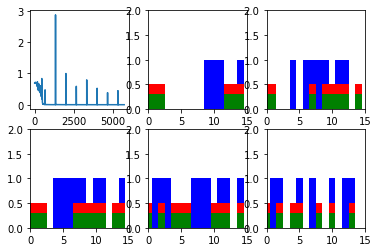

Step 500 Batch loss 0.00026101424


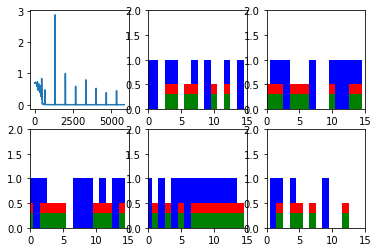

Step 600 Batch loss 0.0002491086


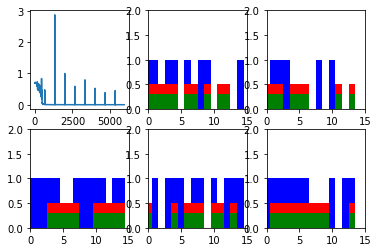

New data, epoch 9
Step 0 Batch loss 0.6554325


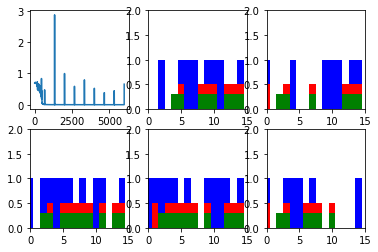

Step 100 Batch loss 0.00032347275


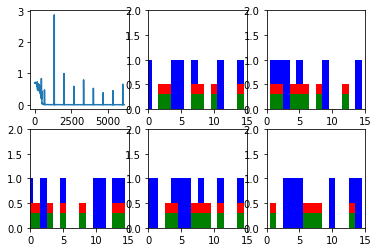

Step 200 Batch loss 0.00028352722


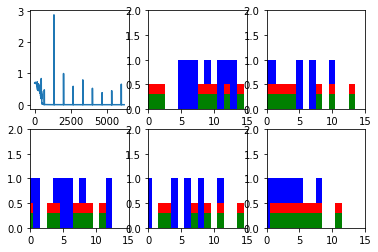

Step 300 Batch loss 0.00029370037


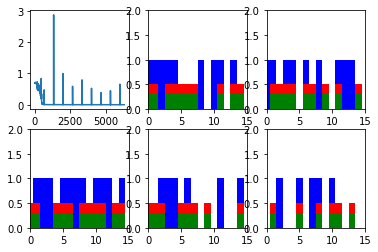

Step 400 Batch loss 0.0002534043


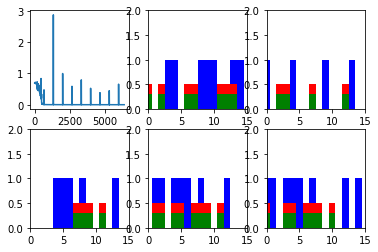

Step 500 Batch loss 0.00025913646


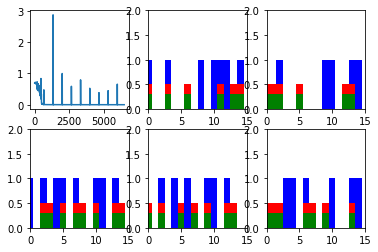

Step 600 Batch loss 0.00023474351


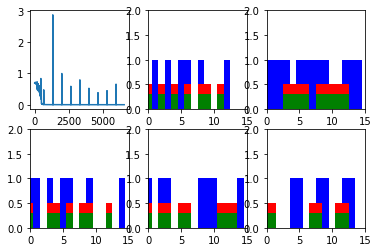

New data, epoch 10
Step 0 Batch loss 0.6652185


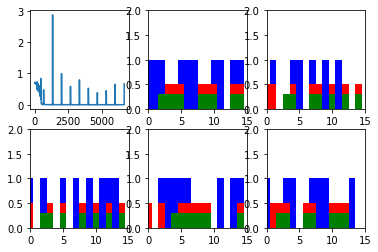

Step 100 Batch loss 0.00030487293


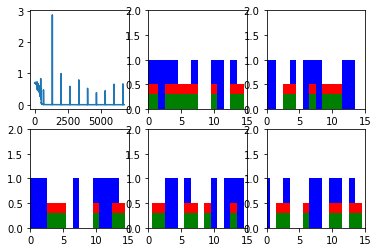

Step 200 Batch loss 0.00026815187


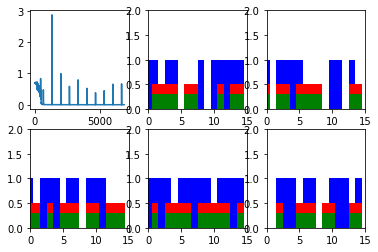

Step 300 Batch loss 0.00026030364


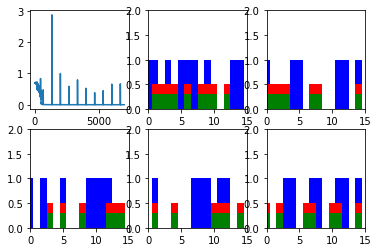

Step 400 Batch loss 0.00021314705


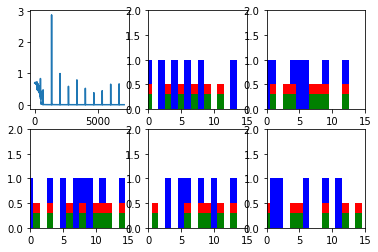

Step 500 Batch loss 0.00021548073


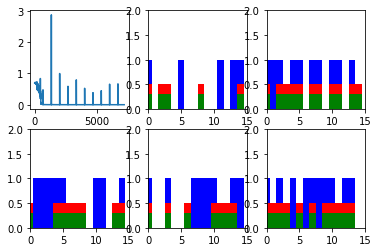

Step 600 Batch loss 0.00021410892


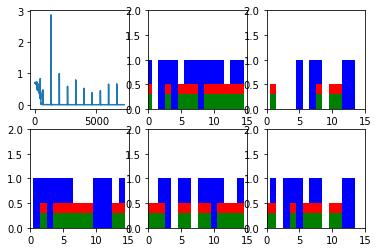

New data, epoch 11
Step 0 Batch loss 0.51591164


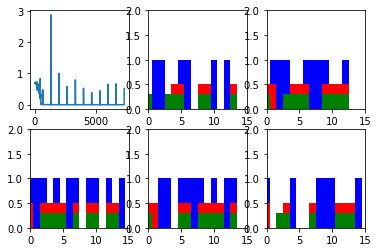

Step 100 Batch loss 0.00025008962


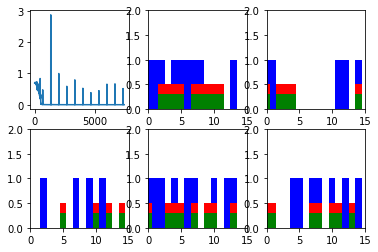

Step 200 Batch loss 0.0002471315


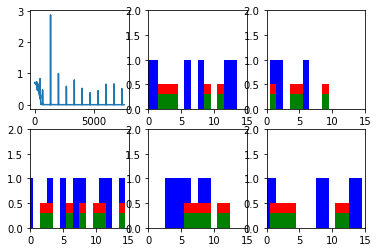

Step 300 Batch loss 0.00021525307


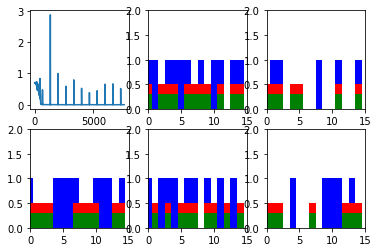

Step 400 Batch loss 0.00019469531


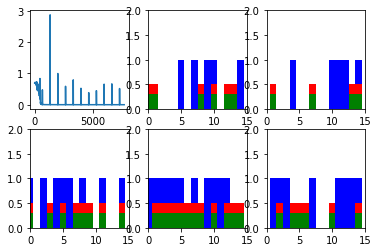

Step 500 Batch loss 0.00018908482


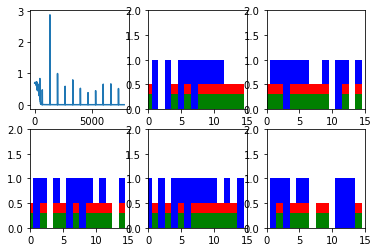

Step 600 Batch loss 0.00019842475


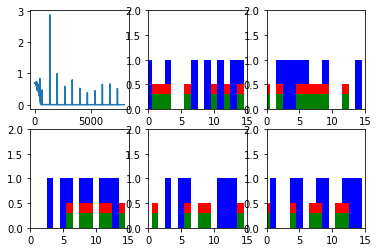

New data, epoch 12
Step 0 Batch loss 0.6568196


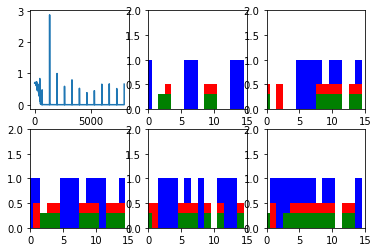

Step 100 Batch loss 0.00025814914


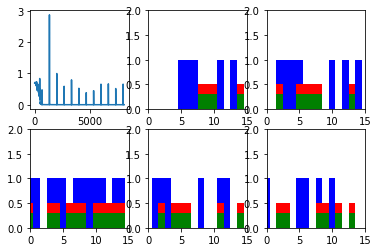

Step 200 Batch loss 0.00020639245


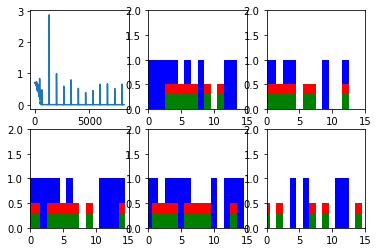

Step 300 Batch loss 0.00026313929


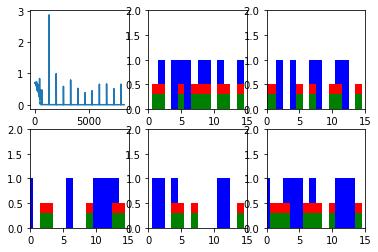

Step 400 Batch loss 0.00021558357


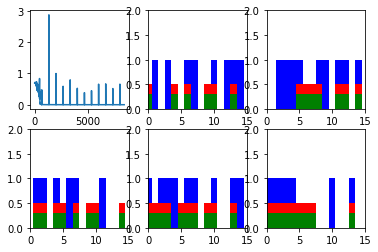

Step 500 Batch loss 0.00020683452


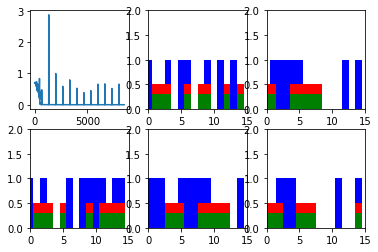

Step 600 Batch loss 0.00018648386


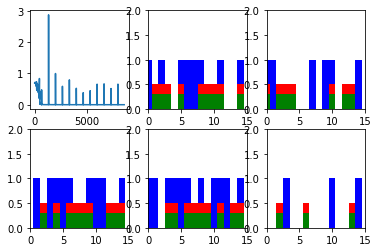

New data, epoch 13
Step 0 Batch loss 0.6128642


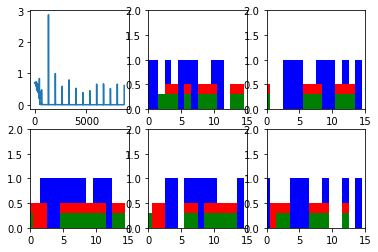

Step 100 Batch loss 0.00020136937


KeyboardInterrupt: 

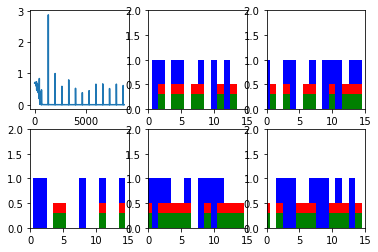

In [16]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

# Dynamic RNN API
https://medium.com/@erikhallstrm/using-the-dynamicrnn-api-in-tensorflow-7237aba7f7ea

logits = tf.matmul(states_series, W2) + b2 #Broadcasted addition
labels = tf.reshape(batchY_placeholder, [-1])

logits_series = tf.unpack(tf.reshape(logits, [batch_size, truncated_backprop_length, num_classes]), axis=1)
predictions_series = [tf.nn.softmax(logit) for logit in logits_list]

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)

In [6]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

In [7]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

In [11]:
state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [13]:
cells = []
for l in range(num_layers):
    cells.append(tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True))
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(batchX_placeholder, -1), initial_state=rnn_tuple_state)
states_series = tf.reshape(states_series, [-1, state_size])

In [14]:
logits = tf.matmul(states_series, W2) + b2 #Broadcasted addition
labels = tf.reshape(batchY_placeholder, [-1])

logits_series = tf.unstack(tf.reshape(logits, [batch_size, truncated_backprop_length, num_classes]), axis=1)
predictions_series = [tf.nn.softmax(logit) for logit in logits_series]

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Batch loss 0.69462144


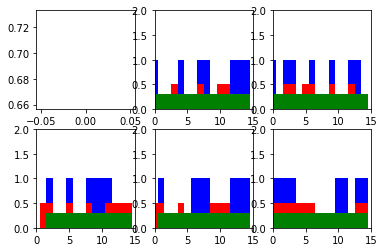

Step 100 Batch loss 0.6403059


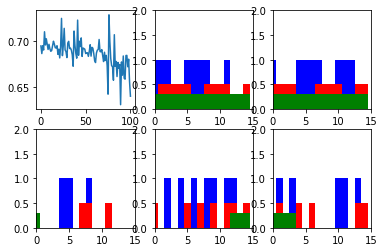

Step 200 Batch loss 0.5330861


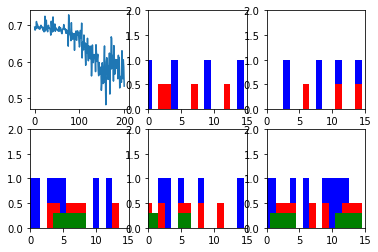

Step 300 Batch loss 0.4560477


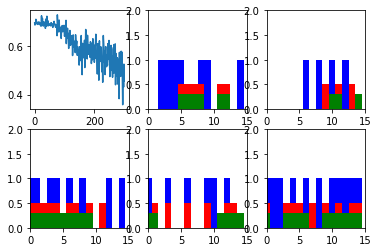

Step 400 Batch loss 0.24546789


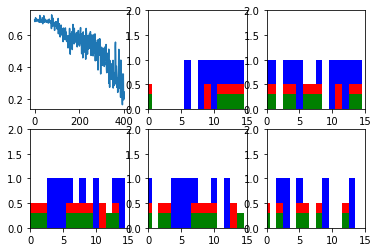

Step 500 Batch loss 0.011403675


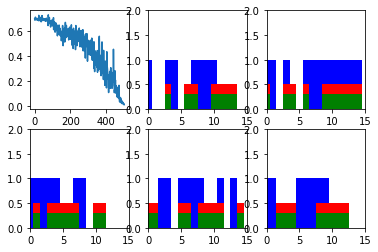

Step 600 Batch loss 0.004564733


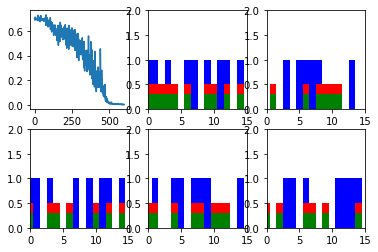

New data, epoch 1
Step 0 Batch loss 0.59189963


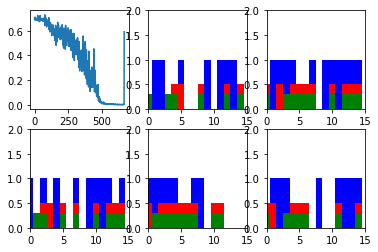

Step 100 Batch loss 0.0022266419


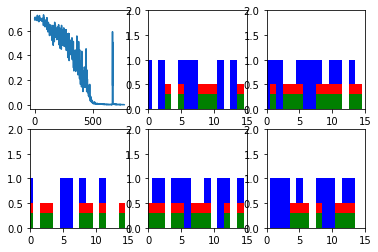

Step 200 Batch loss 0.0015301491


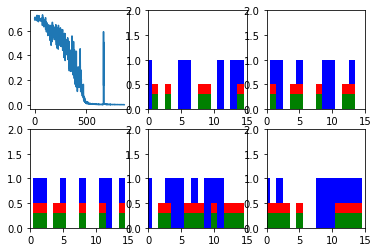

Step 300 Batch loss 0.0013130861


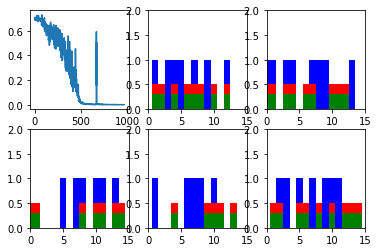

Step 400 Batch loss 0.001014766


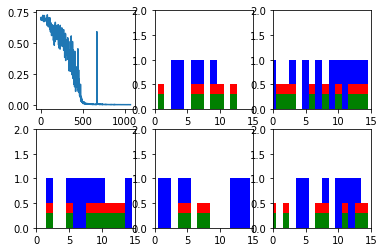

Step 500 Batch loss 0.0007172469


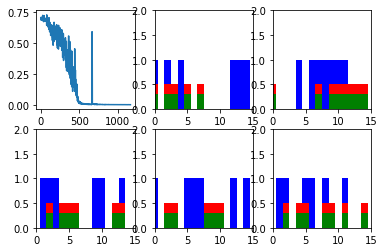

Step 600 Batch loss 0.00066570926


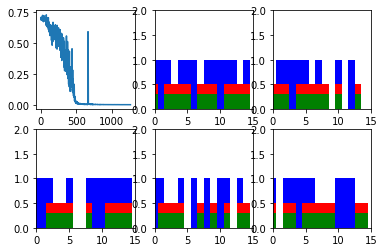

New data, epoch 2
Step 0 Batch loss 0.3979042


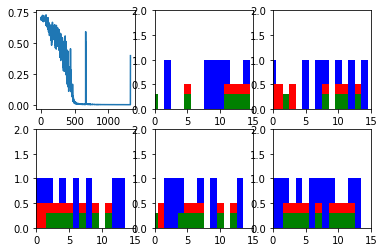

Step 100 Batch loss 0.00081822515


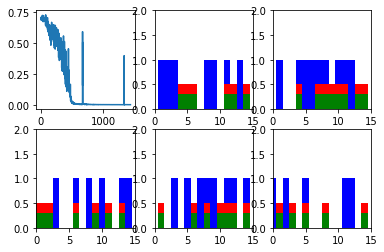

Step 200 Batch loss 0.000649562


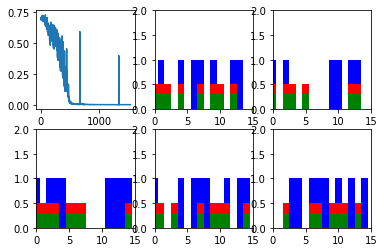

Step 300 Batch loss 0.000654284


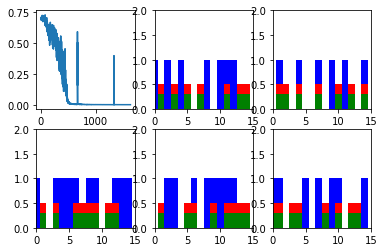

Step 400 Batch loss 0.0005989049


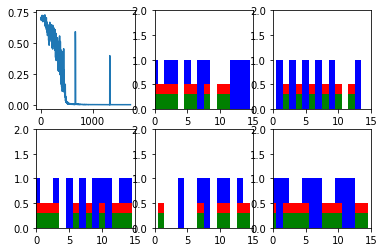

Step 500 Batch loss 0.00042402736


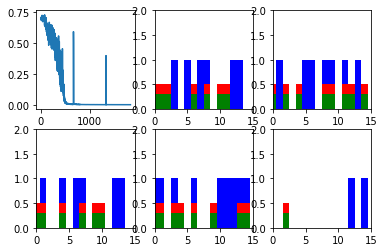

Step 600 Batch loss 0.000498191


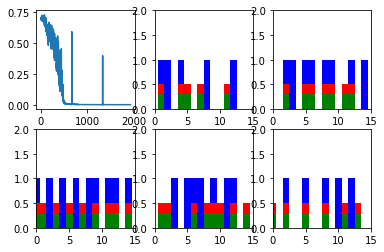

New data, epoch 3
Step 0 Batch loss 0.28890017


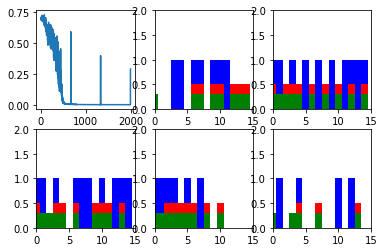

Step 100 Batch loss 0.00082403404


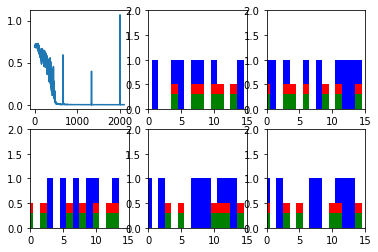

Step 200 Batch loss 0.0004770147


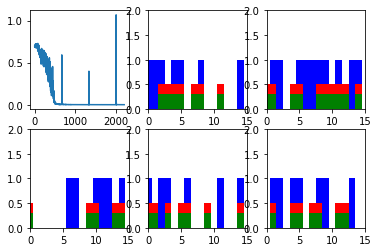

Step 300 Batch loss 0.0004675912


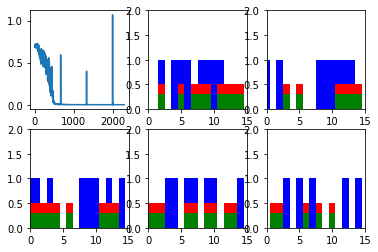

Step 400 Batch loss 0.00046726296


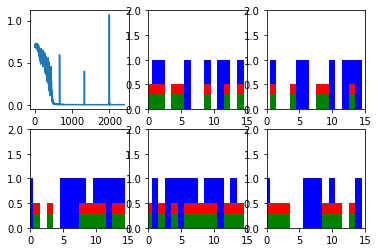

Step 500 Batch loss 0.00045479182


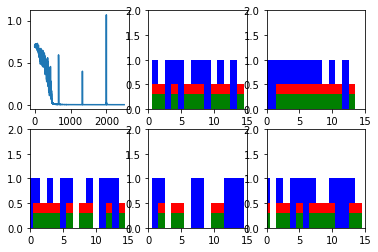

Step 600 Batch loss 0.000337058


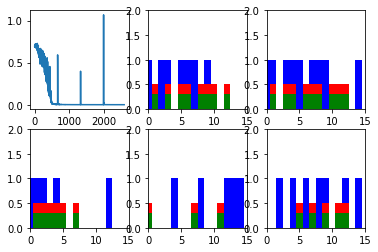

New data, epoch 4
Step 0 Batch loss 0.4139736


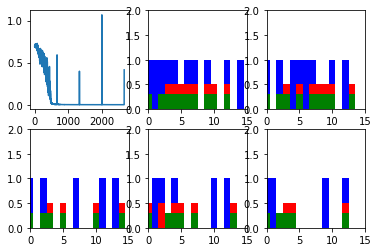

Step 100 Batch loss 0.00034858542


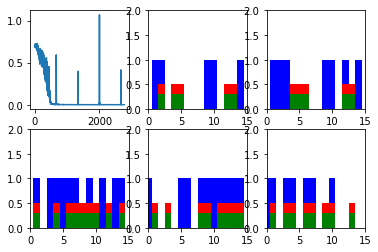

Step 200 Batch loss 0.00029061848


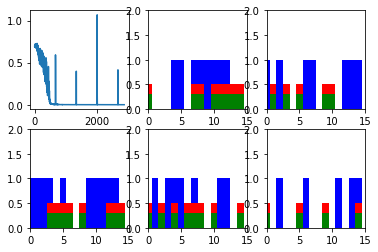

Step 300 Batch loss 0.00025067956


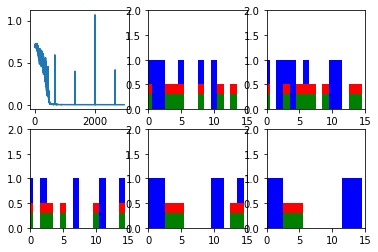

Step 400 Batch loss 0.00024369471


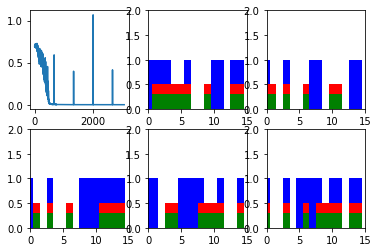

Step 500 Batch loss 0.0002506139


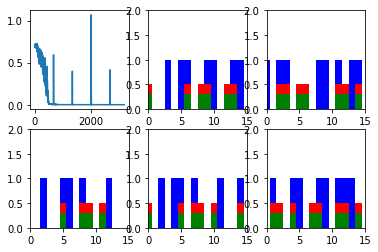

Step 600 Batch loss 0.00024406282


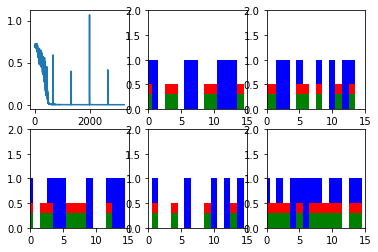

New data, epoch 5
Step 0 Batch loss 0.39618513


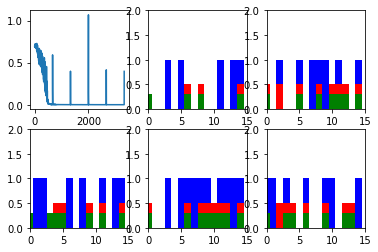

Step 100 Batch loss 0.00024347995


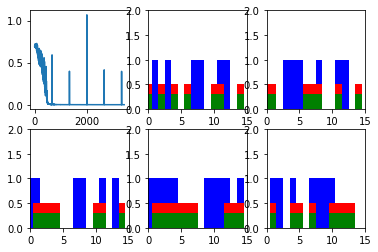

Step 200 Batch loss 0.00025281313


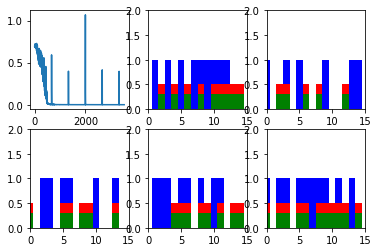

Step 300 Batch loss 0.00020539566


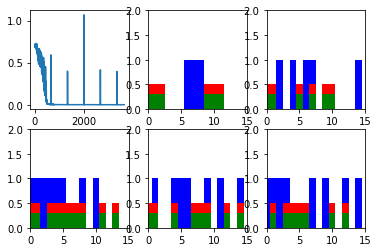

Step 400 Batch loss 0.00021690798


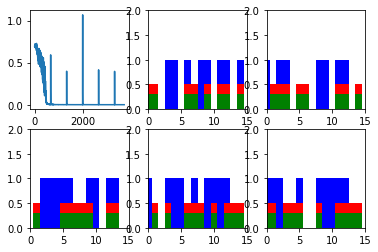

Step 500 Batch loss 0.00020348333


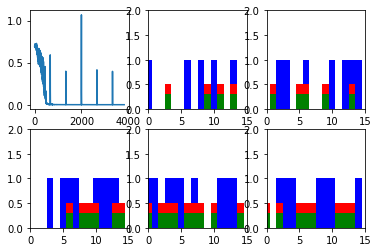

Step 600 Batch loss 0.00018319


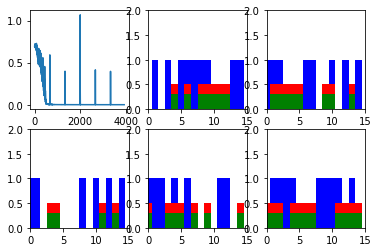

New data, epoch 6
Step 0 Batch loss 0.66694725


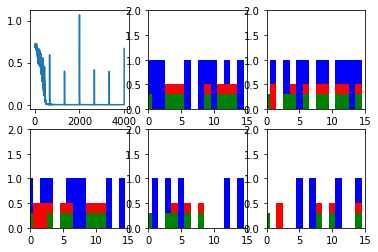

Step 100 Batch loss 0.00020019071


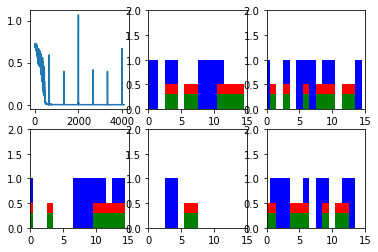

Step 200 Batch loss 0.00021230054


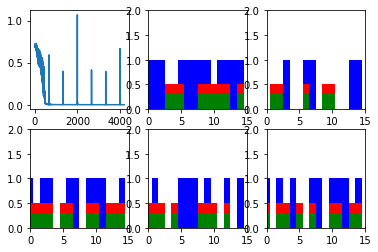

Step 300 Batch loss 0.00017080053


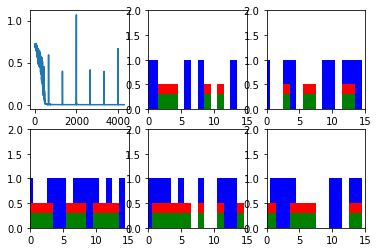

Step 400 Batch loss 0.00020071829


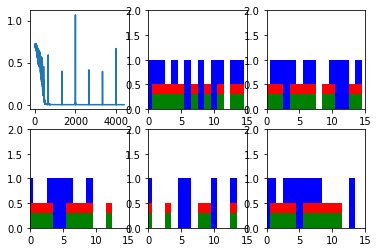

Step 500 Batch loss 0.00018426323


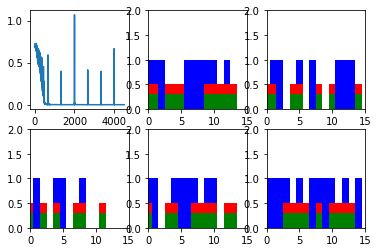

Step 600 Batch loss 0.0001786654


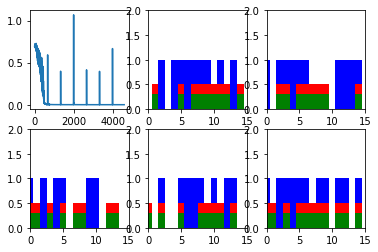

New data, epoch 7
Step 0 Batch loss 0.70549023


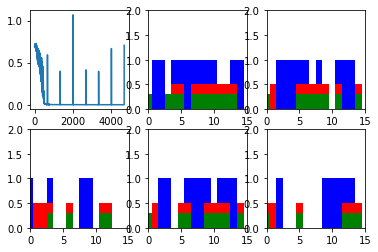

Step 100 Batch loss 0.00019922701


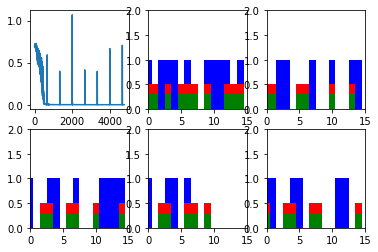

Step 200 Batch loss 0.00017593557


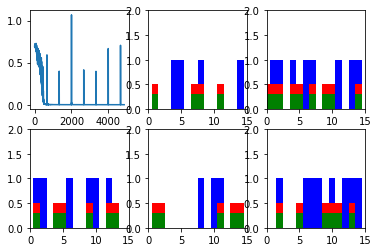

Step 300 Batch loss 0.00016970292


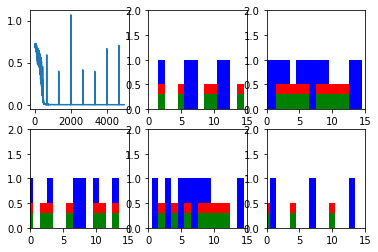

Step 400 Batch loss 0.00017887873


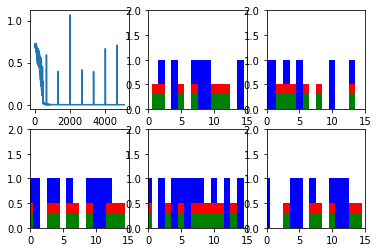

Step 500 Batch loss 0.0001442471


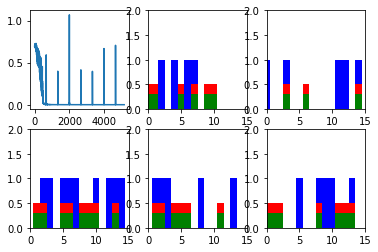

Step 600 Batch loss 0.00015375964


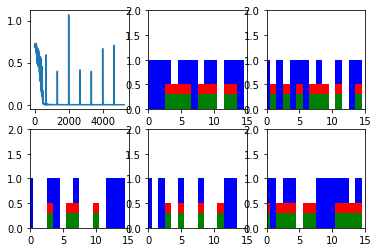

New data, epoch 8
Step 0 Batch loss 0.47492212


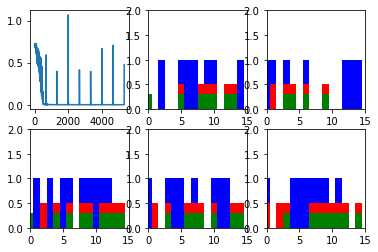

Step 100 Batch loss 0.00017672102


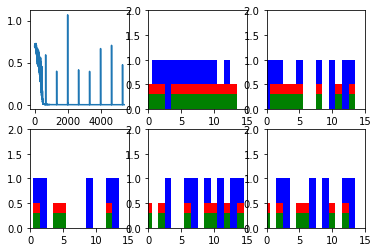

Step 200 Batch loss 0.00014205706


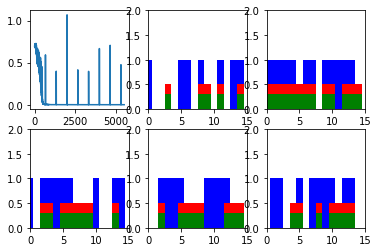

Step 300 Batch loss 0.00014955053


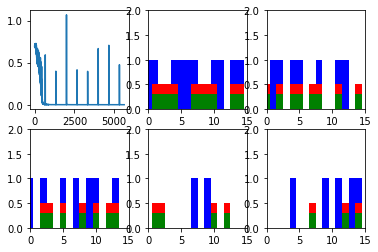

Step 400 Batch loss 0.00014298932


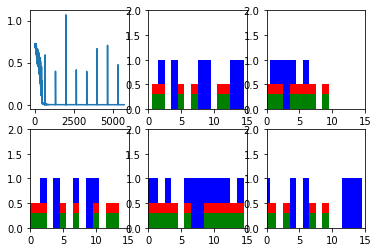

Step 500 Batch loss 0.00014204219


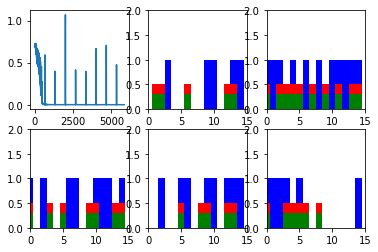

Step 600 Batch loss 0.00013350036


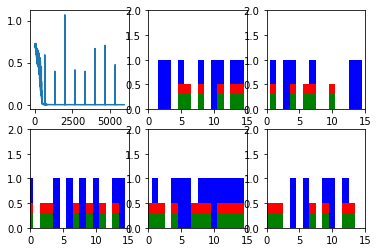

New data, epoch 9
Step 0 Batch loss 0.7015376


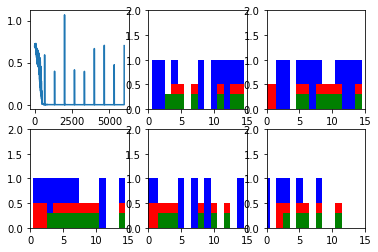

Step 100 Batch loss 0.00020066673


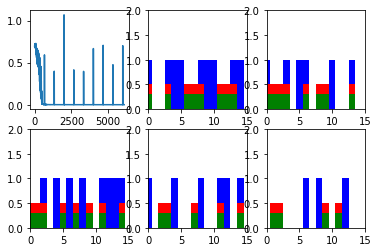

Step 200 Batch loss 0.00015156831


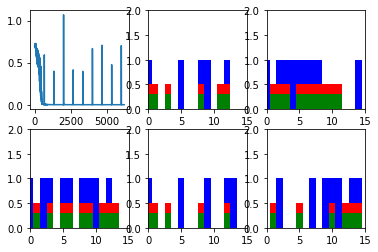

Step 300 Batch loss 0.00013563372


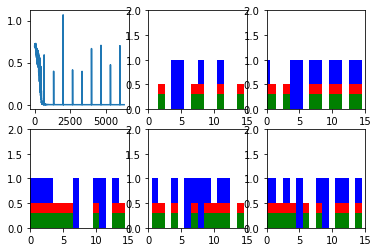

Step 400 Batch loss 0.00013222758


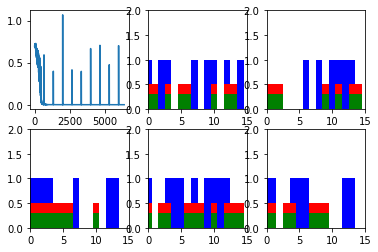

Step 500 Batch loss 0.00015432577


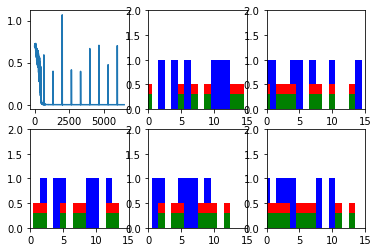

Step 600 Batch loss 0.00014407876


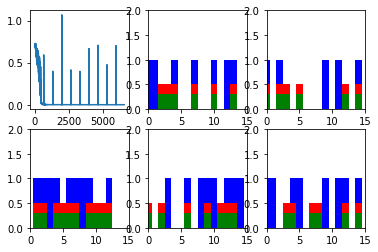

New data, epoch 10
Step 0 Batch loss 0.57007074


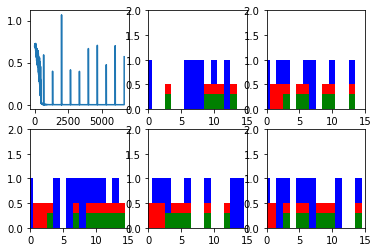

Step 100 Batch loss 0.00020309168


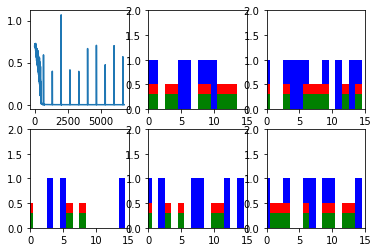

Step 200 Batch loss 0.00013806956


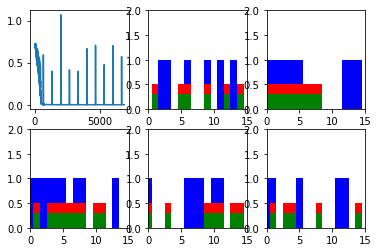

Step 300 Batch loss 0.00015679267


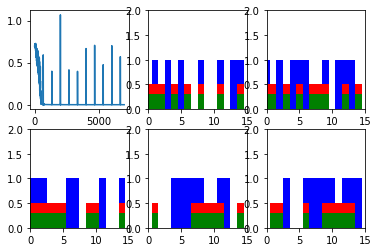

Step 400 Batch loss 0.00014979264


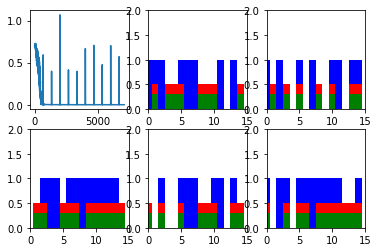

Step 500 Batch loss 0.00013528438


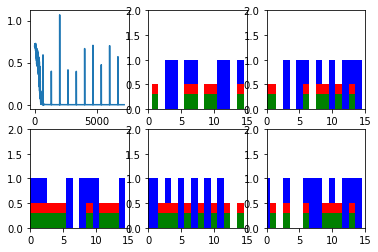

Step 600 Batch loss 0.00012954207


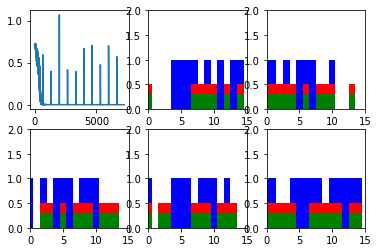

New data, epoch 11
Step 0 Batch loss 0.77198404


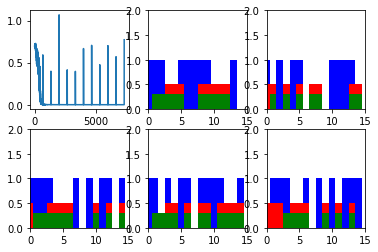

Step 100 Batch loss 0.00019985987


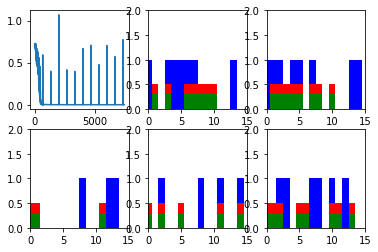

Step 200 Batch loss 0.00018815658


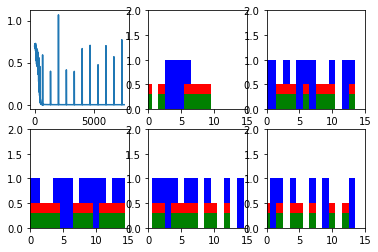

Step 300 Batch loss 0.00015372517


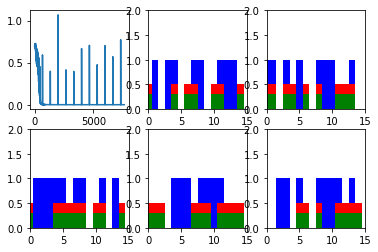

Step 400 Batch loss 0.00015308762


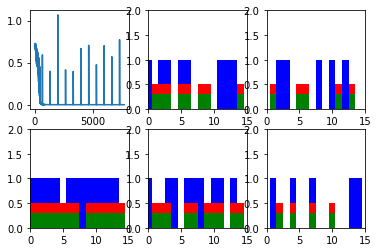

Step 500 Batch loss 0.00012647577


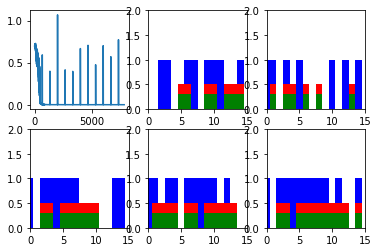

Step 600 Batch loss 0.00015316278


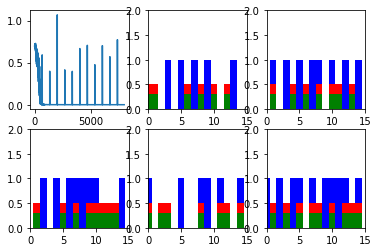

New data, epoch 12
Step 0 Batch loss 0.44704905


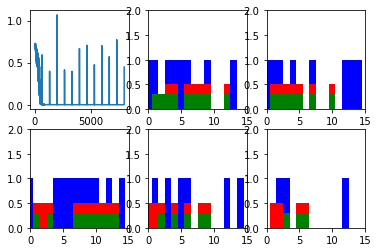

Step 100 Batch loss 0.00019912994


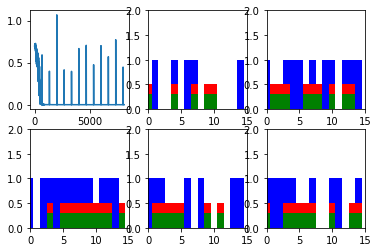

Step 200 Batch loss 0.00017792913


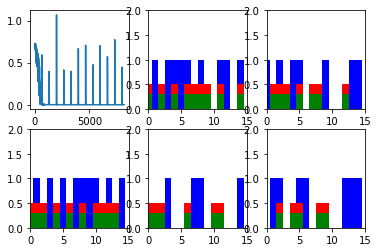

Step 300 Batch loss 0.00016118737


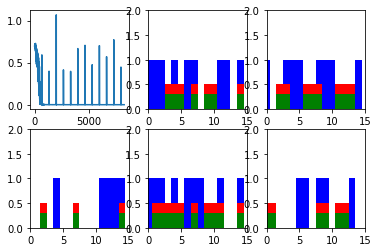

Step 400 Batch loss 0.00013914079


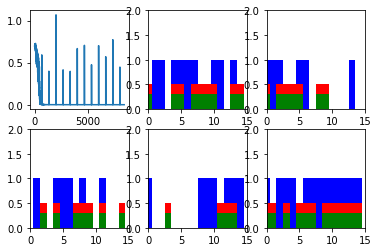

Step 500 Batch loss 0.00014415495


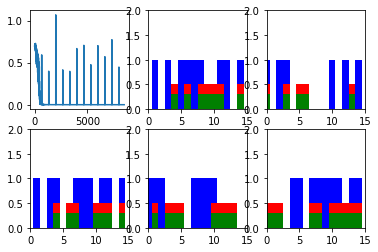

Step 600 Batch loss 9.900126e-05


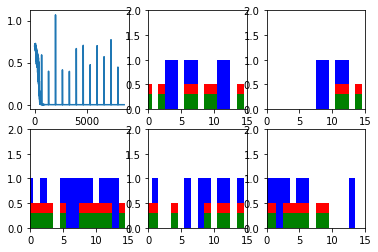

New data, epoch 13
Step 0 Batch loss 0.41073528


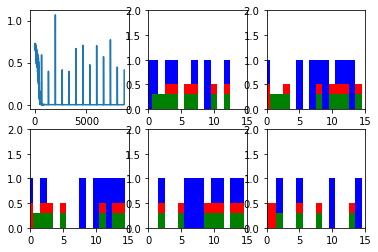

Step 100 Batch loss 0.0009897884


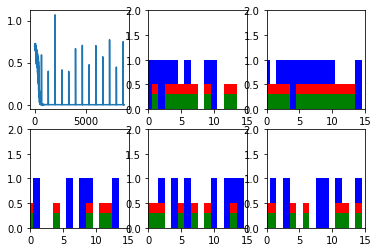

Step 200 Batch loss 0.00042810012


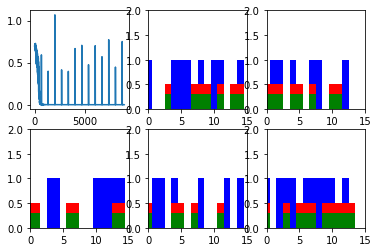

Step 300 Batch loss 0.00041239464


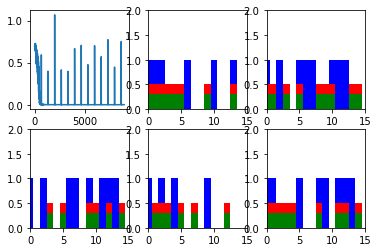

Step 400 Batch loss 0.00035769984


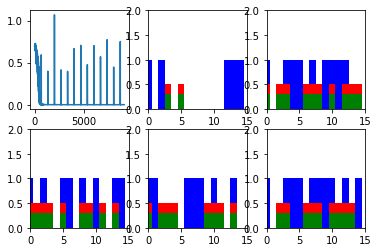

Step 500 Batch loss 0.0002505757


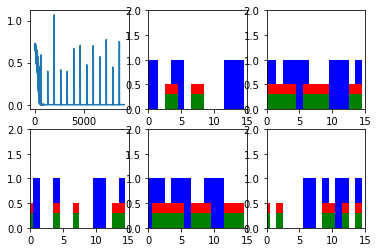

Step 600 Batch loss 0.0002042584


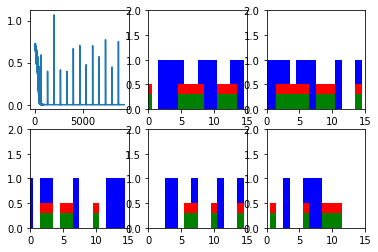

New data, epoch 14
Step 0 Batch loss 0.3625364


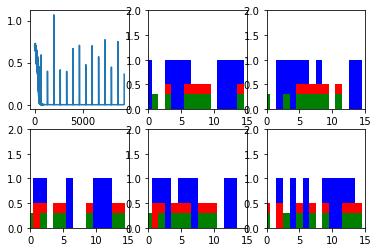

Step 100 Batch loss 0.0002875854


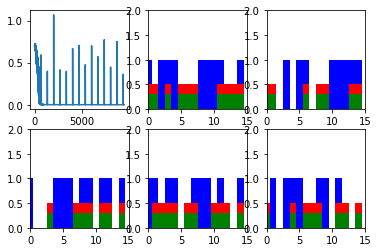

Step 200 Batch loss 0.00023715876


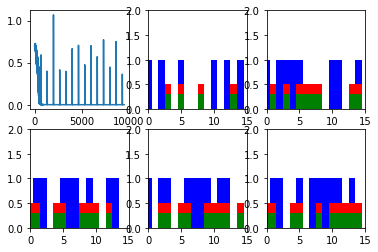

Step 300 Batch loss 0.00025518273


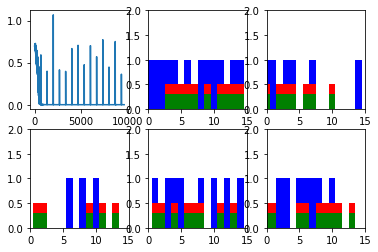

Step 400 Batch loss 0.00022542775


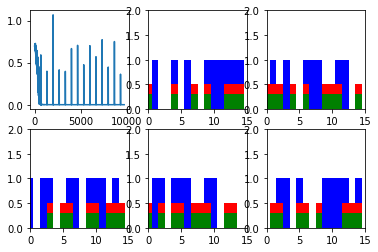

Step 500 Batch loss 0.00015973883


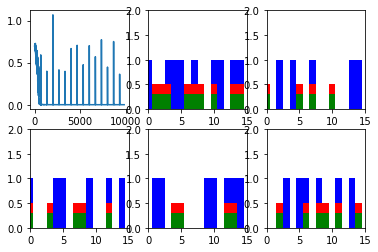

Step 600 Batch loss 0.00017446843


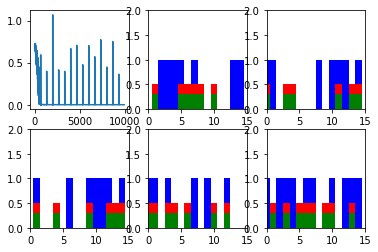

New data, epoch 15
Step 0 Batch loss 0.51592


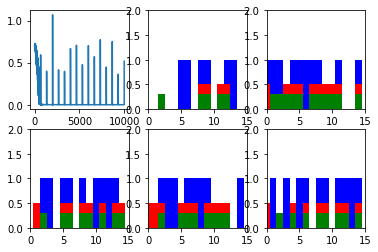

Step 100 Batch loss 0.00022438513


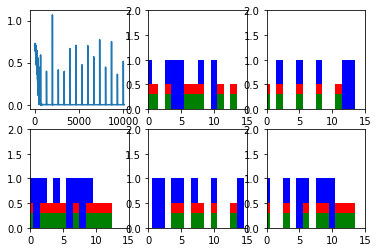

Step 200 Batch loss 0.00019000995


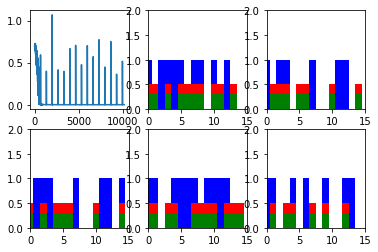

Step 300 Batch loss 0.00017601653


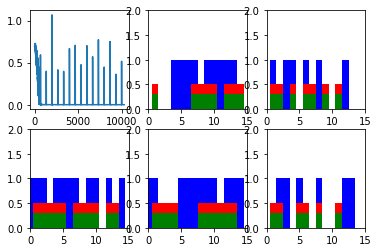

Step 400 Batch loss 0.00014197198


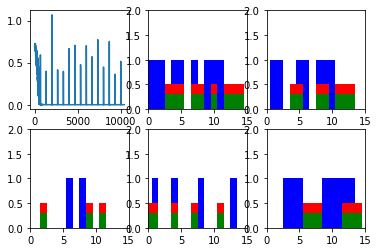

Step 500 Batch loss 0.0001588454


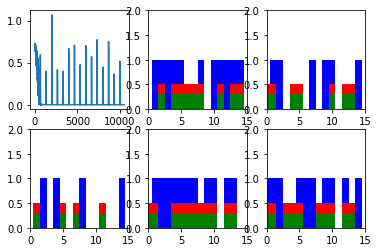

Step 600 Batch loss 0.00016186092


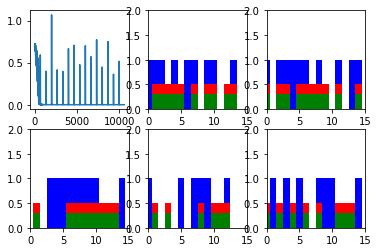

New data, epoch 16
Step 0 Batch loss 0.33341405


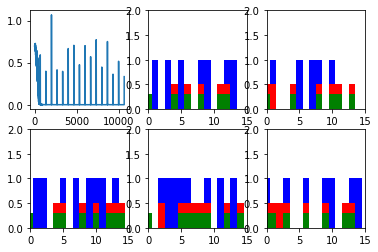

Step 100 Batch loss 0.00018796202


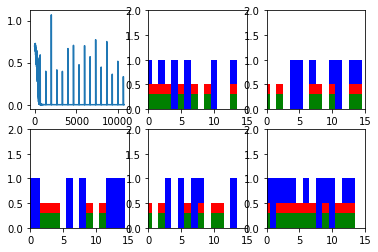

Step 200 Batch loss 0.0001475322


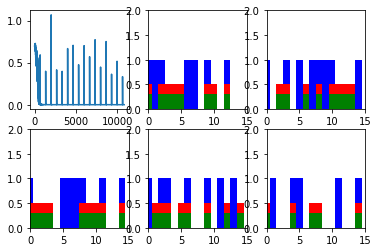

Step 300 Batch loss 0.00013919313


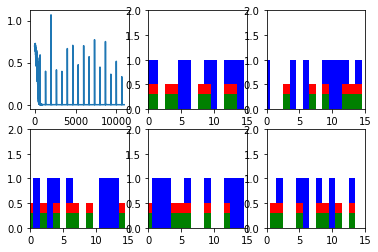

Step 400 Batch loss 0.000121400655


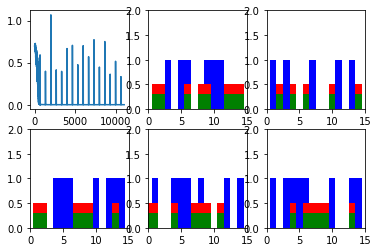

Step 500 Batch loss 0.00012538415


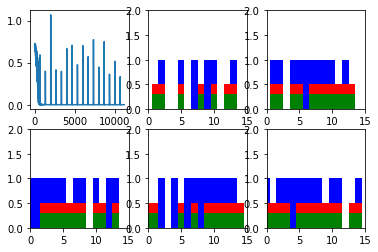

Step 600 Batch loss 0.000126348


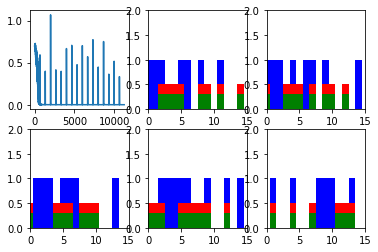

New data, epoch 17
Step 0 Batch loss 0.27615955


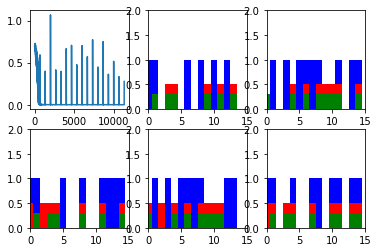

Step 100 Batch loss 0.00011413091


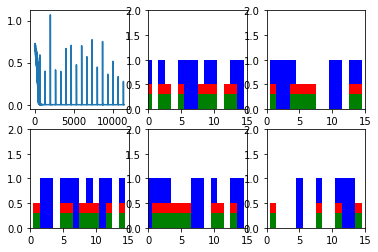

Step 200 Batch loss 0.00012616026


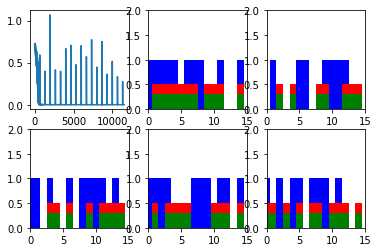

Step 300 Batch loss 0.0001170844


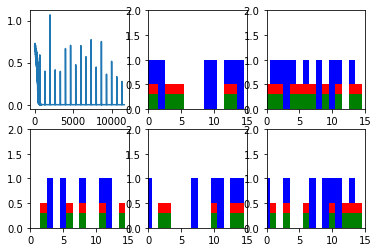

Step 400 Batch loss 0.00011075015


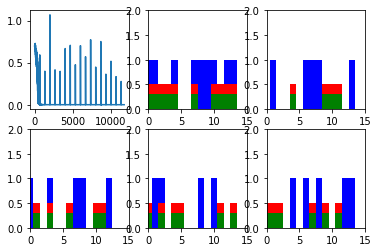

Step 500 Batch loss 9.677185e-05


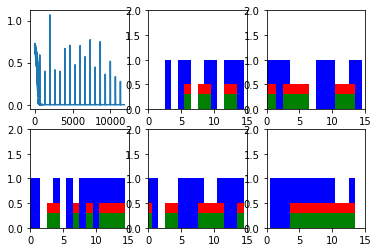

Step 600 Batch loss 0.00010936171


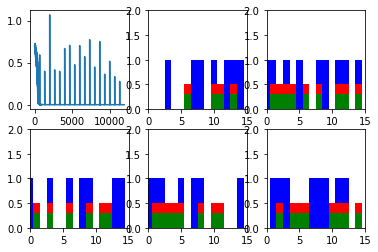

New data, epoch 18
Step 0 Batch loss 0.27728036


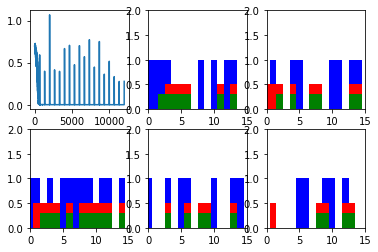

Step 100 Batch loss 0.000120370074


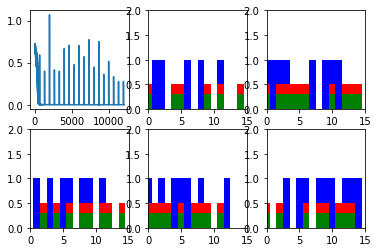

Step 200 Batch loss 0.00012167257


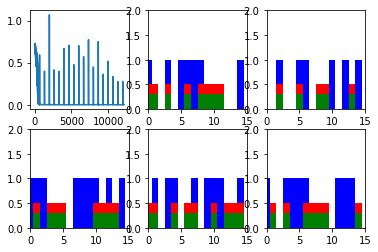

Step 300 Batch loss 0.000115299474


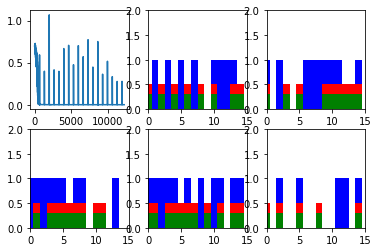

Step 400 Batch loss 0.00010562373


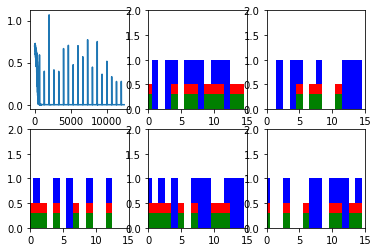

Step 500 Batch loss 0.00010663352


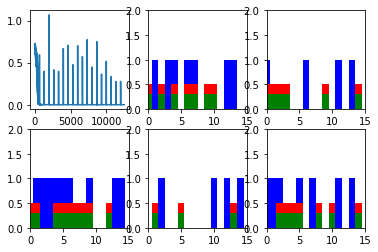

Step 600 Batch loss 8.45541e-05


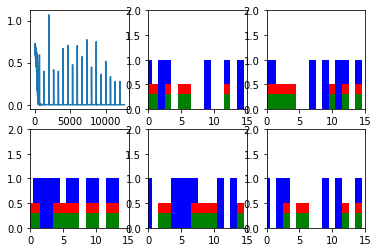

New data, epoch 19
Step 0 Batch loss 0.16948073


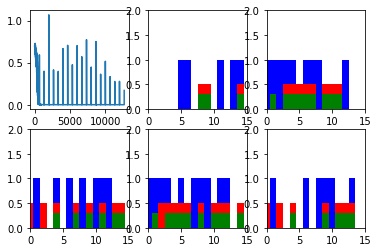

Step 100 Batch loss 8.913559e-05


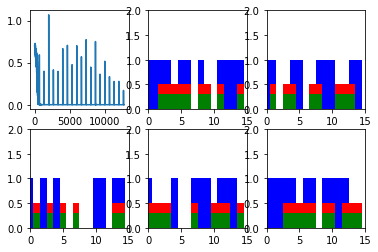

Step 200 Batch loss 9.106041e-05


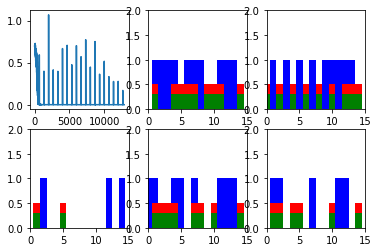

Step 300 Batch loss 8.5186235e-05


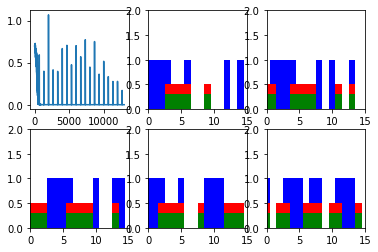

Step 400 Batch loss 8.568552e-05


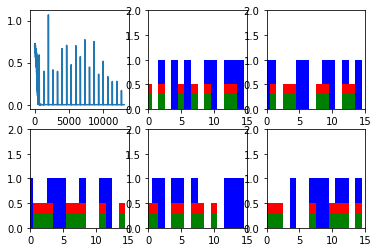

Step 500 Batch loss 8.628632e-05


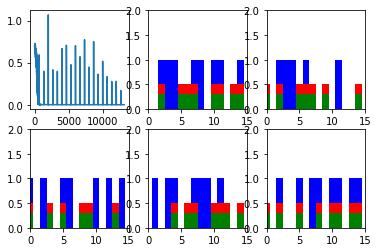

Step 600 Batch loss 8.9613175e-05


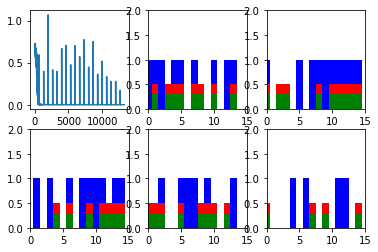

New data, epoch 20
Step 0 Batch loss 0.46787563


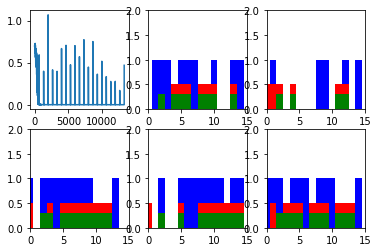

Step 100 Batch loss 0.0001193131


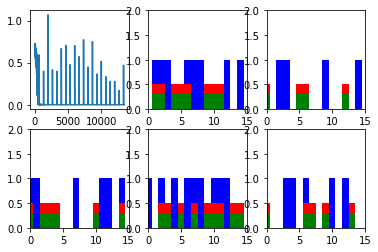

Step 200 Batch loss 9.625699e-05


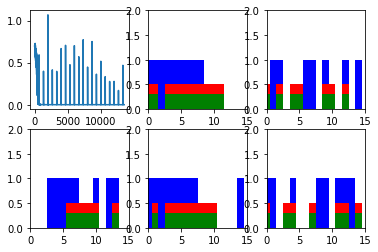

Step 300 Batch loss 0.00010274808


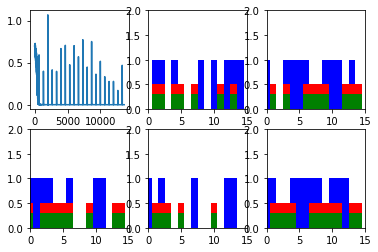

Step 400 Batch loss 7.903248e-05


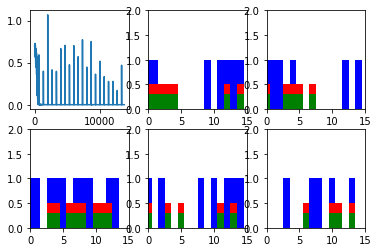

Step 500 Batch loss 8.2644736e-05


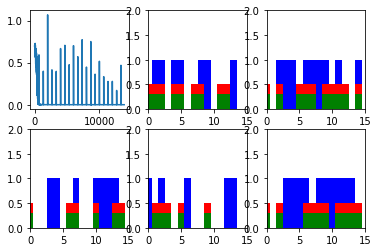

Step 600 Batch loss 7.527247e-05


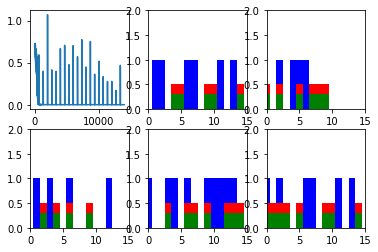

New data, epoch 21
Step 0 Batch loss 0.46513498


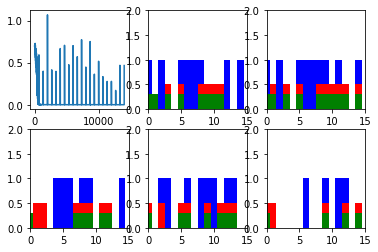

Step 100 Batch loss 0.00010563305


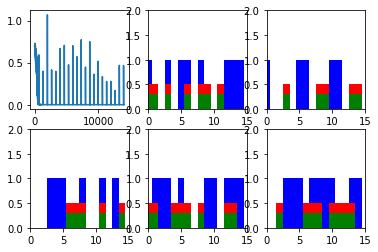

Step 200 Batch loss 9.7159274e-05


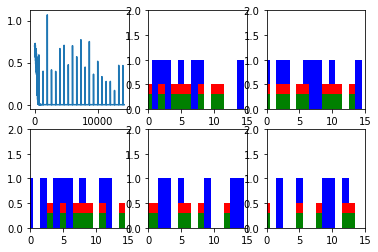

Step 300 Batch loss 9.643067e-05


KeyboardInterrupt: 

In [15]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

## Regularization
https://medium.com/@erikhallstrm/using-the-dropout-api-in-tensorflow-2b2e6561dfeb

cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True)
cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)

In [16]:
num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

In [6]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

In [13]:
state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [8]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [15]:
# Forward passes
#cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True, reuse=True)
#cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
cells = []
for l in range(num_layers):
    cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=Truewith tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show())
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
    cells.append(cell)
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(batchX_placeholder, -1),
                                                 initial_state=rnn_tuple_state)
states_series = tf.reshape(states_series, [-1, state_size])

logits = tf.matmul(states_series, W2) + b2 #Broadcasted addition
labels = tf.reshape(batchY_placeholder, [-1])

logits_series = tf.unstack(tf.reshape(logits, [batch_size, truncated_backprop_length, 2]), axis=1)
predictions_series = [tf.nn.softmax(logit) for logit in logits_series]

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Batch loss 0.6929688


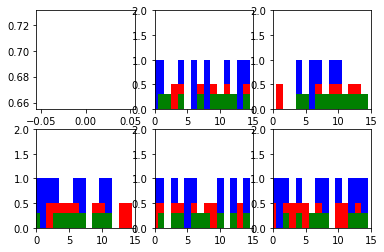

Step 100 Batch loss 0.6954956


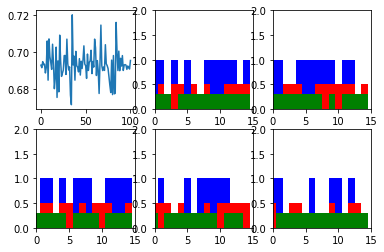

Step 200 Batch loss 0.7002546


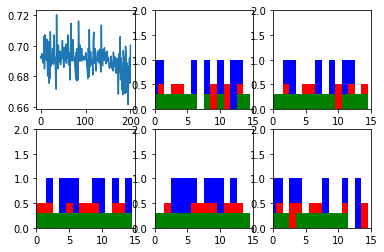

Step 300 Batch loss 0.57871366


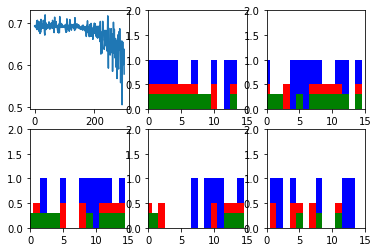

Step 400 Batch loss 0.5939695


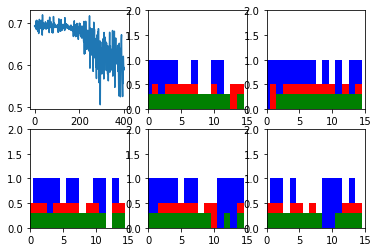

Step 500 Batch loss 0.60475427


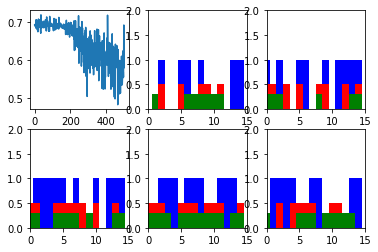

Step 600 Batch loss 0.5576292


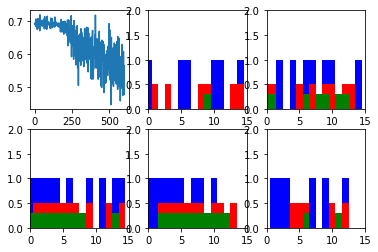

New data, epoch 1
Step 0 Batch loss 0.4871638


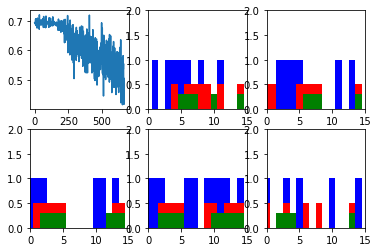

Step 100 Batch loss 0.41920424


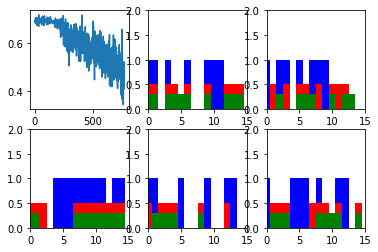

Step 200 Batch loss 0.31294614


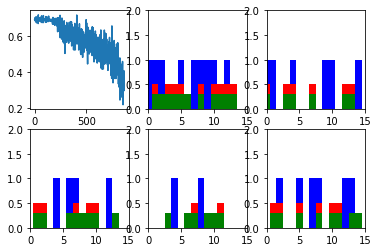

Step 300 Batch loss 0.42661774


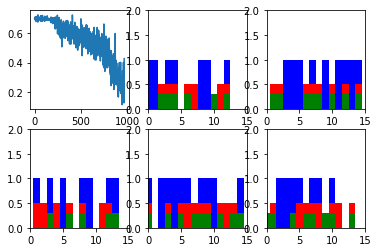

Step 400 Batch loss 0.20004034


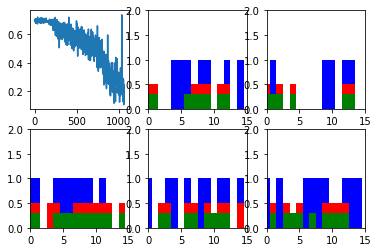

Step 500 Batch loss 0.25433797


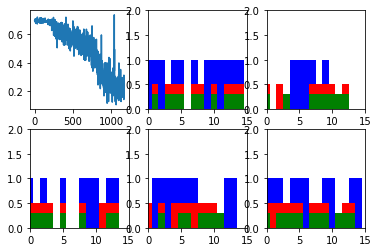

Step 600 Batch loss 0.2032494


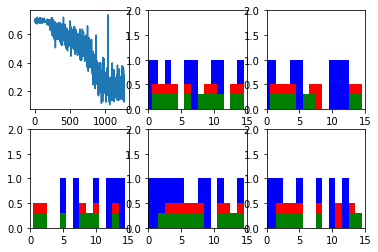

New data, epoch 2
Step 0 Batch loss 0.43561286


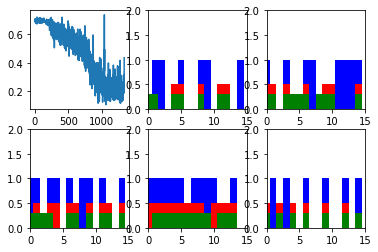

Step 100 Batch loss 0.16278562


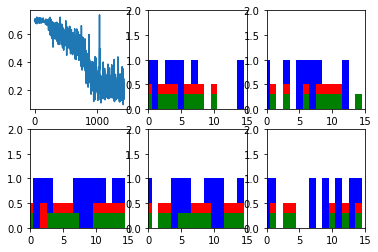

Step 200 Batch loss 0.19558659


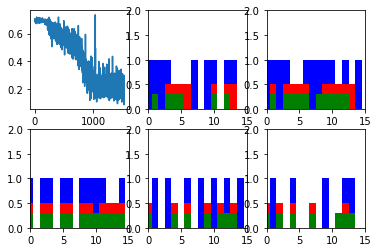

Step 300 Batch loss 0.30000505


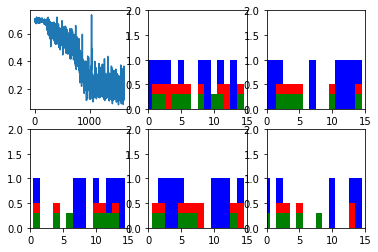

Step 400 Batch loss 0.16154401


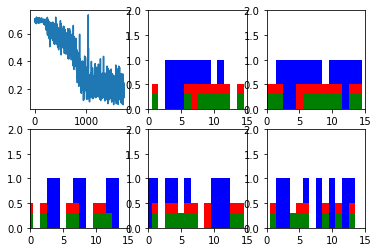

Step 500 Batch loss 0.1886921


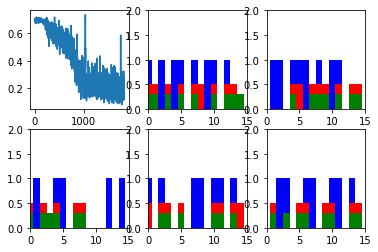

Step 600 Batch loss 0.109658815


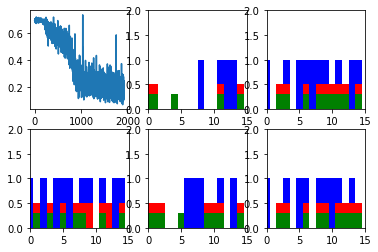

New data, epoch 3
Step 0 Batch loss 0.6052768


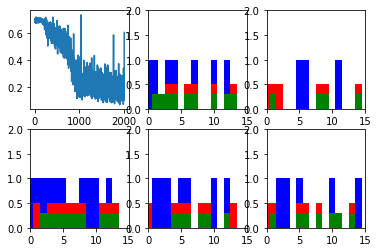

Step 100 Batch loss 0.13835937


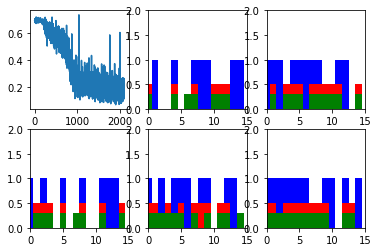

Step 200 Batch loss 0.17098038


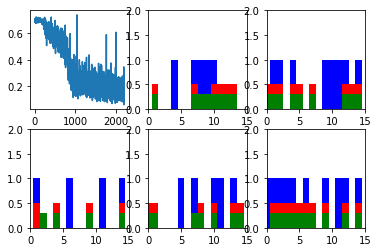

Step 300 Batch loss 0.13769978


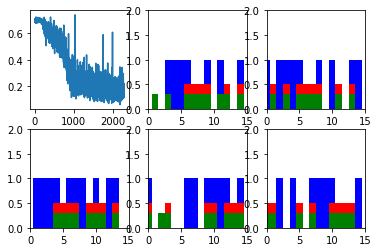

Step 400 Batch loss 0.10130726


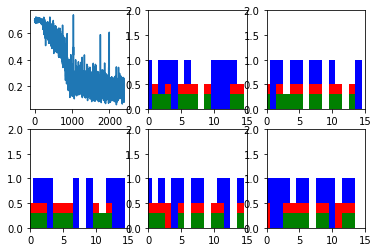

Step 500 Batch loss 0.1967591


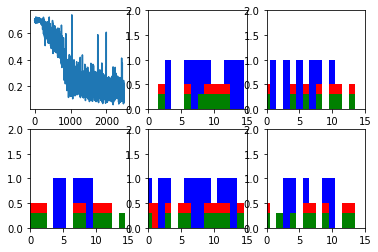

Step 600 Batch loss 0.2203034


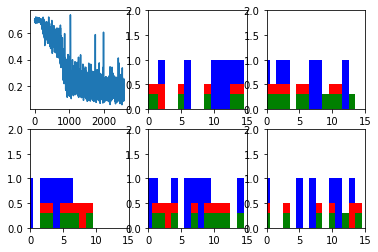

New data, epoch 4
Step 0 Batch loss 0.46089447


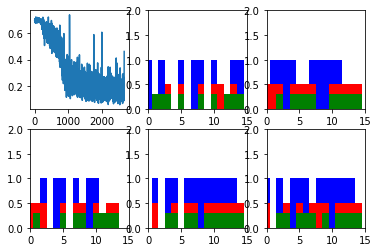

Step 100 Batch loss 0.097451195


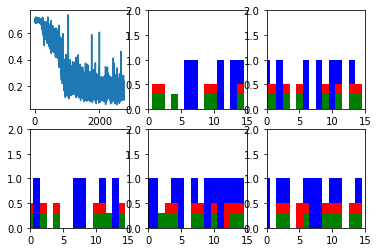

Step 200 Batch loss 0.41533235


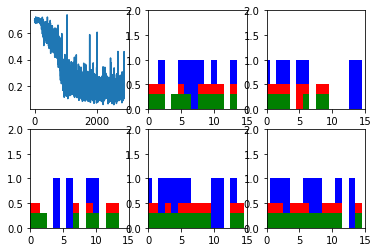

Step 300 Batch loss 0.15700059


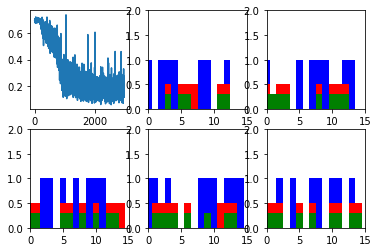

Step 400 Batch loss 0.21913075


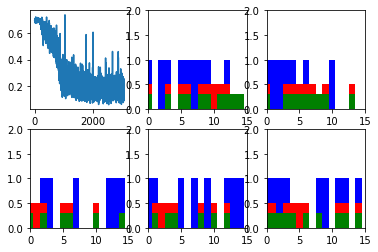

Step 500 Batch loss 0.19718121


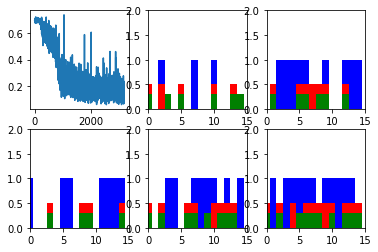

Step 600 Batch loss 0.087576464


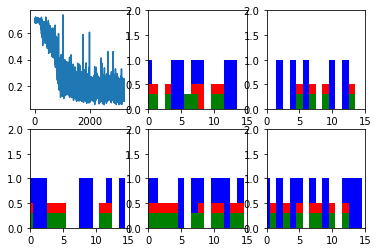

New data, epoch 5
Step 0 Batch loss 0.34818193


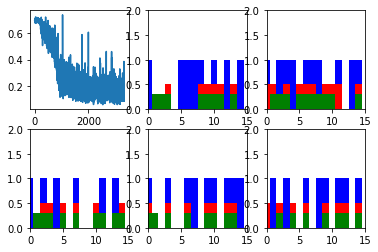

Step 100 Batch loss 0.10820887


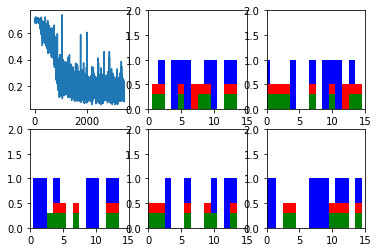

Step 200 Batch loss 0.15518722


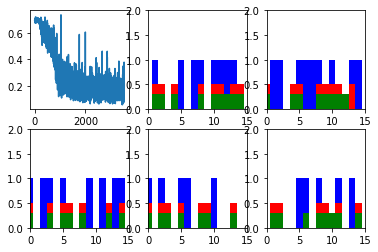

Step 300 Batch loss 0.15856141


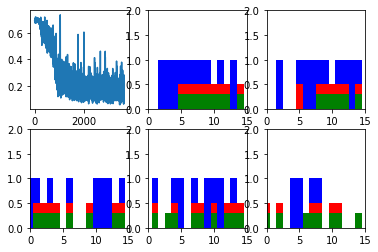

Step 400 Batch loss 0.1631305


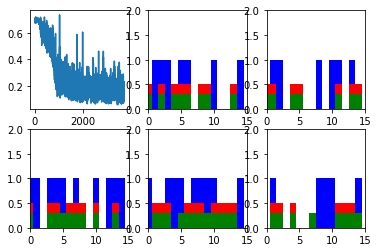

Step 500 Batch loss 0.07454713


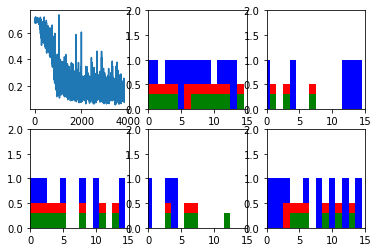

Step 600 Batch loss 0.122998826


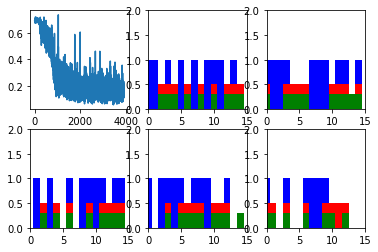

New data, epoch 6
Step 0 Batch loss 0.38226745


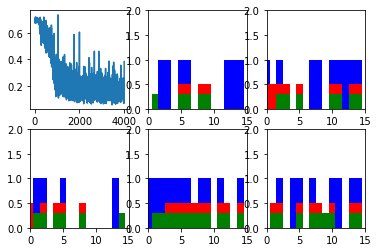

Step 100 Batch loss 0.22846888


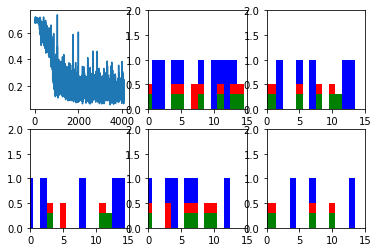

Step 200 Batch loss 0.09558049


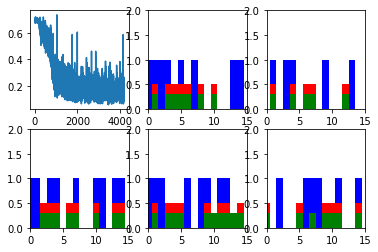

Step 300 Batch loss 0.13415973


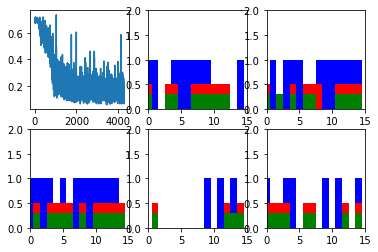

Step 400 Batch loss 0.1253299


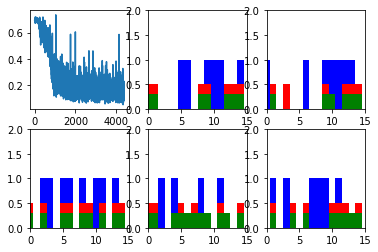

Step 500 Batch loss 0.13484524


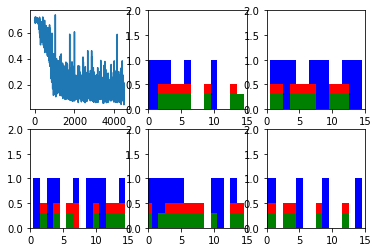

Step 600 Batch loss 0.12309661


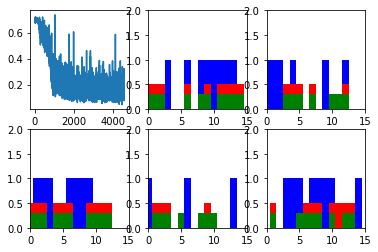

New data, epoch 7
Step 0 Batch loss 0.49858776


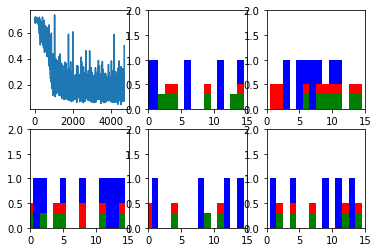

Step 100 Batch loss 0.17712341


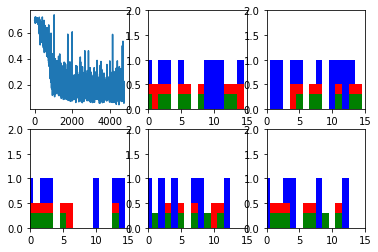

Step 200 Batch loss 0.08960713


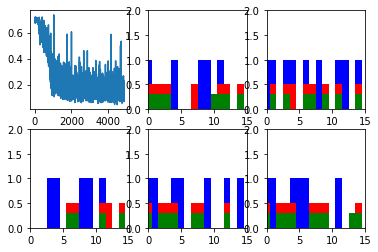

Step 300 Batch loss 0.20791616


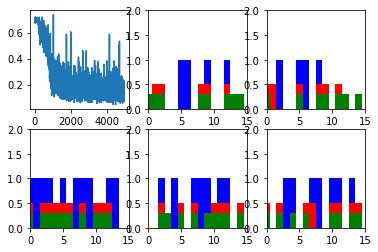

Step 400 Batch loss 0.14790417


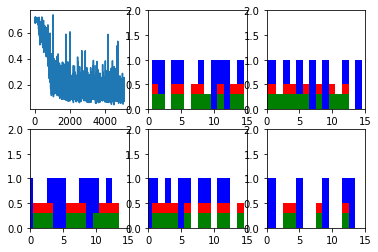

Step 500 Batch loss 0.13240221


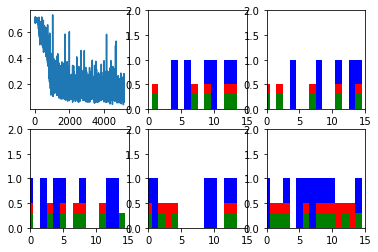

Step 600 Batch loss 0.21758533


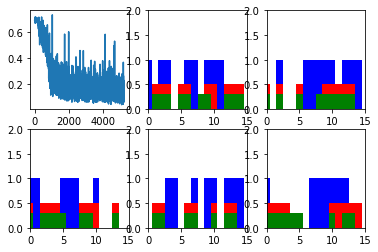

New data, epoch 8
Step 0 Batch loss 0.45786998


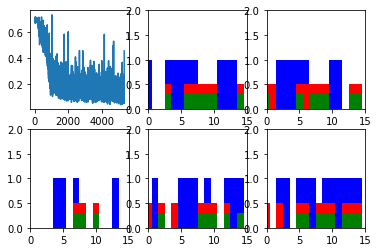

Step 100 Batch loss 0.17983684


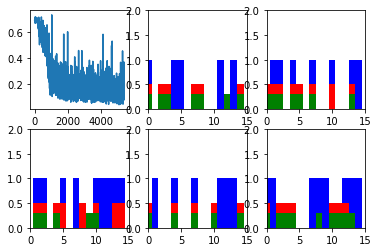

Step 200 Batch loss 0.11675018


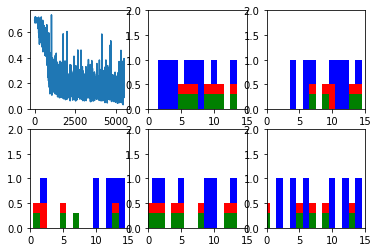

Step 300 Batch loss 0.15271305


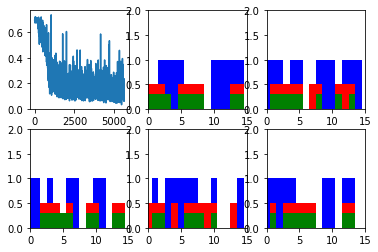

Step 400 Batch loss 0.21675894


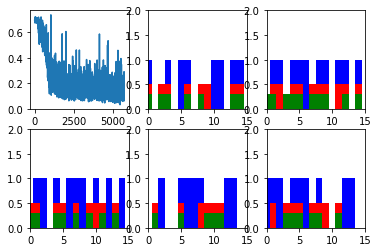

Step 500 Batch loss 0.14125304


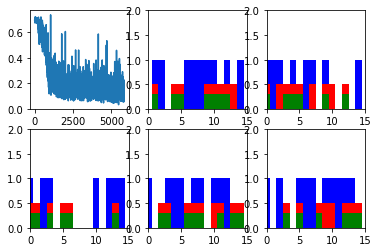

Step 600 Batch loss 0.081797935


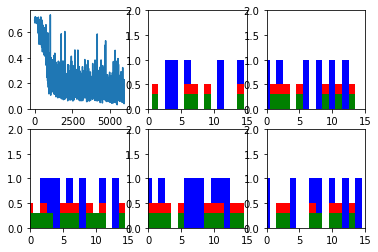

New data, epoch 9
Step 0 Batch loss 0.42411888


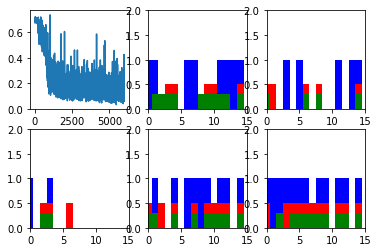

Step 100 Batch loss 0.08109849


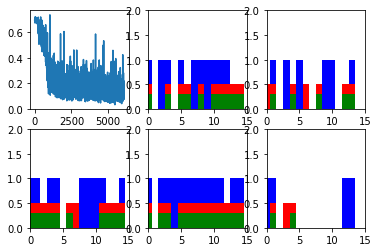

Step 200 Batch loss 0.13136278


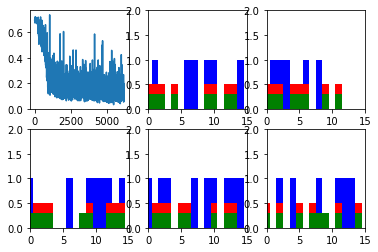

Step 300 Batch loss 0.15327615


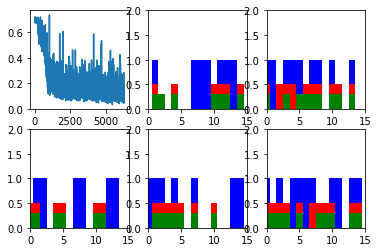

Step 400 Batch loss 0.13441864


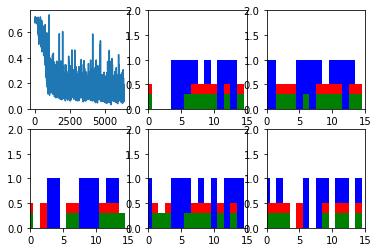

Step 500 Batch loss 0.17704493


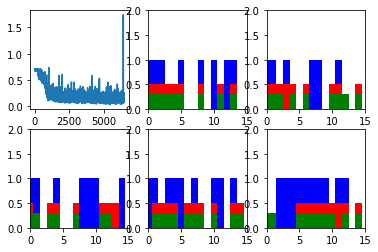

Step 600 Batch loss 0.28483298


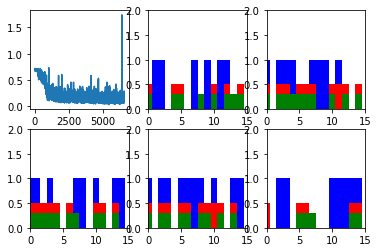

In [17]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()